In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


2025-05-28 02:42:45.535435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748400165.834635      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748400165.915769      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist = {
    'units': [32, 64, 128],              # số neuron mỗi layer
    'dropout': [0.2, 0.3, 0.5],          # dropout giữa các lớp
    'batch_size': [16, 32, 64],          # batch size khi huấn luyện
    'epochs': [10, 20, 30],              # số epoch huấn luyện
    'learning_rate': [0.001, 0.0005],    # tốc độ học
}


In [4]:
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

def build_lstm_model(input_shape, num_classes, units=64, dropout=0.3):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_phase(phase_path, random_state=42, sample=False, units=64, dropout=0.3, batch_size=32, epochs=30):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Reshape cho LSTM: (samples, timesteps=1, features)
        X_train_lstm = np.expand_dims(X_train_scaled.values, axis=1)
        X_val_lstm = np.expand_dims(X_val_scaled.values, axis=1)

        # Xử lý nhãn
        classes = np.unique(np.concatenate((y_train, y_val)))
        y_train_cat = to_categorical(np.searchsorted(classes, y_train), num_classes=len(classes))
        y_val_cat = to_categorical(np.searchsorted(classes, y_val), num_classes=len(classes))

        # Build model
        input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
        model = build_lstm_model(input_shape, num_classes=len(classes), units=units, dropout=dropout)

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            X_train_lstm, y_train_cat,
            validation_data=(X_val_lstm, y_val_cat),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=2
        )

        # Predict
        y_proba = model.predict(X_val_lstm)
        y_pred = np.argmax(y_proba, axis=1)
        y_val_idx = np.searchsorted(classes, y_val)

        acc = accuracy_score(y_val_idx, y_pred)
        f1 = f1_score(y_val_idx, y_pred, average='macro')
        y_val_bin = label_binarize(y_val_idx, classes=range(len(classes)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val_idx, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_val_idx, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========



2025-05-28 02:43:03.948790: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
340/340 - 13s - 38ms/step - accuracy: 0.6560 - loss: 0.9942 - val_accuracy: 0.6575 - val_loss: 0.8663
Epoch 2/30
340/340 - 2s - 6ms/step - accuracy: 0.6579 - loss: 0.8594 - val_accuracy: 0.6630 - val_loss: 0.8263
Epoch 3/30
340/340 - 2s - 6ms/step - accuracy: 0.6655 - loss: 0.8280 - val_accuracy: 0.6762 - val_loss: 0.7944
Epoch 4/30
340/340 - 2s - 6ms/step - accuracy: 0.6732 - loss: 0.8106 - val_accuracy: 0.6858 - val_loss: 0.7829
Epoch 5/30
340/340 - 2s - 6ms/step - accuracy: 0.6794 - loss: 0.7939 - val_accuracy: 0.6906 - val_loss: 0.7713
Epoch 6/30
340/340 - 2s - 6ms/step - accuracy: 0.6807 - loss: 0.7805 - val_accuracy: 0.6932 - val_loss: 0.7666
Epoch 7/30
340/340 - 2s - 6ms/step - accuracy: 0.6867 - loss: 0.7719 - val_accuracy: 0.6987 - val_loss: 0.7549
Epoch 8/30
340/340 - 2s - 6ms/step - accuracy: 0.6898 - loss: 0.7630 - val_accuracy: 0.6980 - val_loss: 0.7548
Epoch 9/30
340/340 - 2s - 6ms/step - accuracy: 0.6902 - loss: 0.7599 - val_accuracy: 0.6924 - val_loss: 0.7520

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


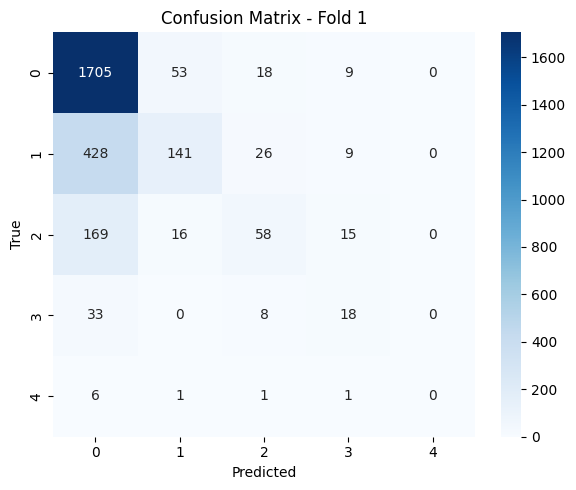

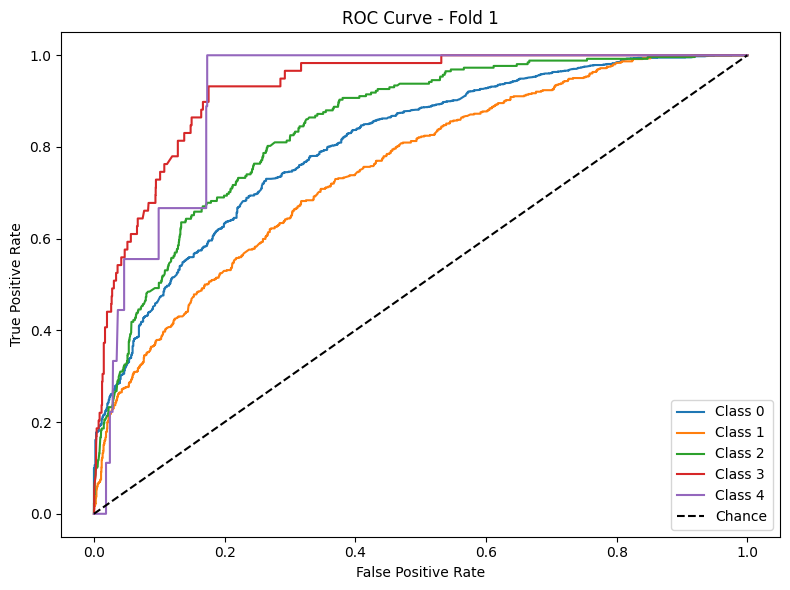

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 12s - 36ms/step - accuracy: 0.6562 - loss: 0.9930 - val_accuracy: 0.6581 - val_loss: 0.8544
Epoch 2/30
340/340 - 2s - 6ms/step - accuracy: 0.6606 - loss: 0.8431 - val_accuracy: 0.6629 - val_loss: 0.8343
Epoch 3/30
340/340 - 2s - 6ms/step - accuracy: 0.6629 - loss: 0.8181 - val_accuracy: 0.6817 - val_loss: 0.8071
Epoch 4/30
340/340 - 2s - 6ms/step - accuracy: 0.6724 - loss: 0.7992 - val_accuracy: 0.6769 - val_loss: 0.7904
Epoch 5/30
340/340 - 2s - 6ms/step - accuracy: 0.6852 - loss: 0.7862 - val_accuracy: 0.6828 - val_loss: 0.7852
Epoch 6/30
340/340 - 2s - 6ms/step - accuracy: 0.6855 - loss: 0.7771 - val_accuracy: 0.6920 - val_loss: 0.7759
Epoch 7/30
340/340 - 2s - 6ms/step - accuracy: 0.6902 - loss: 0.7658 - val_accuracy: 0.6938 - val_loss: 0.7634
Epoch 8/30
340/340 - 2s - 6ms/step - accuracy: 0.6946 - loss: 0.7629 - val_accuracy: 0.6813 - val_loss: 0.7808
Epoch 9/30
340/340 - 2s - 5ms/step - accuracy: 0.6933 - loss: 0.7588 - val_accuracy: 0.6872 - val_loss: 0.7634
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


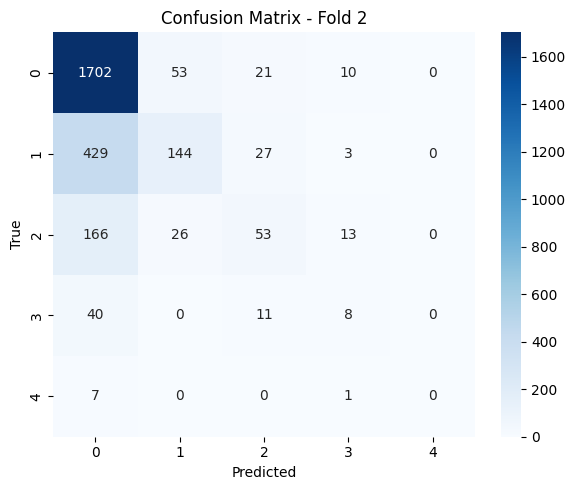

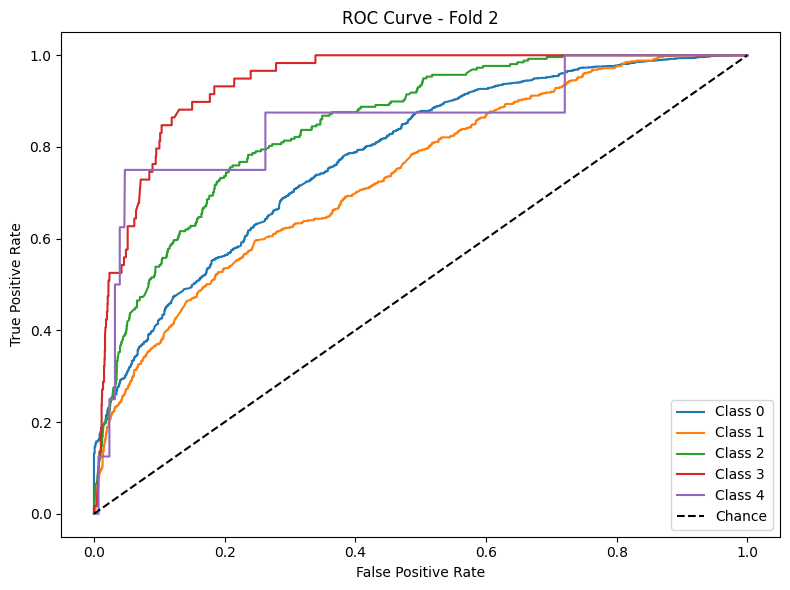

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 13s - 37ms/step - accuracy: 0.6564 - loss: 0.9980 - val_accuracy: 0.6584 - val_loss: 0.8532
Epoch 2/30
340/340 - 2s - 6ms/step - accuracy: 0.6584 - loss: 0.8586 - val_accuracy: 0.6581 - val_loss: 0.8205
Epoch 3/30
340/340 - 2s - 5ms/step - accuracy: 0.6645 - loss: 0.8297 - val_accuracy: 0.6625 - val_loss: 0.7992
Epoch 4/30
340/340 - 2s - 6ms/step - accuracy: 0.6739 - loss: 0.8052 - val_accuracy: 0.6688 - val_loss: 0.7752
Epoch 5/30
340/340 - 2s - 6ms/step - accuracy: 0.6832 - loss: 0.7934 - val_accuracy: 0.6761 - val_loss: 0.7684
Epoch 6/30
340/340 - 2s - 5ms/step - accuracy: 0.6873 - loss: 0.7787 - val_accuracy: 0.6776 - val_loss: 0.7581
Epoch 7/30
340/340 - 2s - 5ms/step - accuracy: 0.6860 - loss: 0.7752 - val_accuracy: 0.6835 - val_loss: 0.7559
Epoch 8/30
340/340 - 2s - 6ms/step - accuracy: 0.6892 - loss: 0.7666 - val_accuracy: 0.6920 - val_loss: 0.7483
Epoch 9/30
340/340 - 2s - 6ms/step - accuracy: 0.6906 - loss: 0.7635 - val_accuracy: 0.6931 - val_loss: 0.7498
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


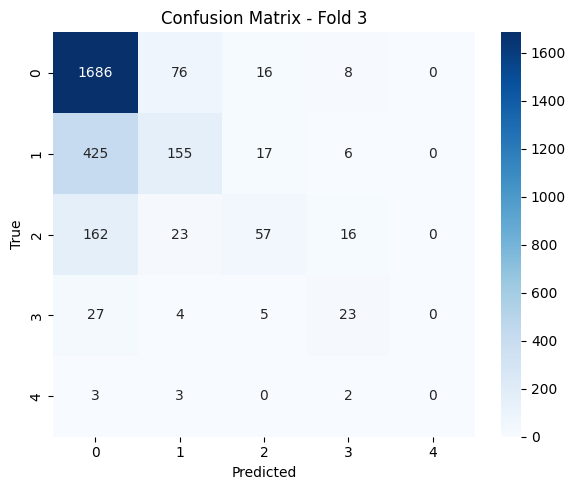

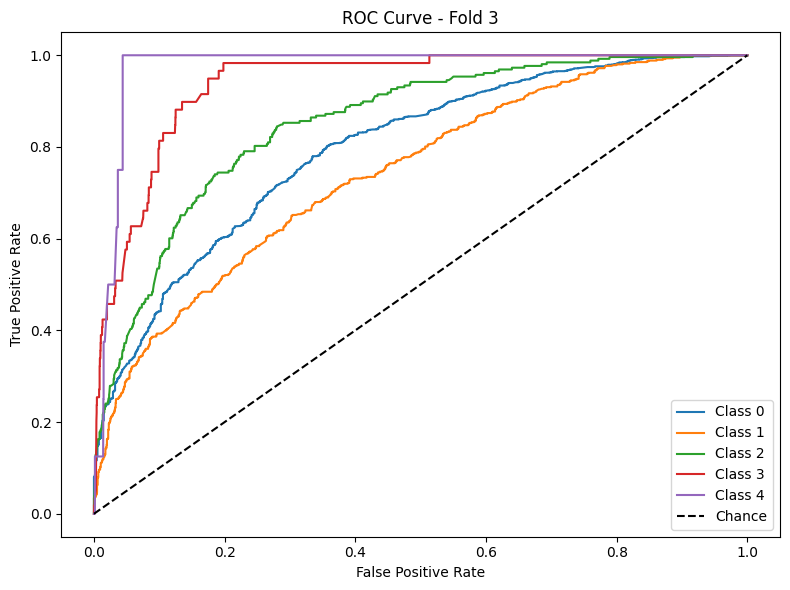

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 12s - 36ms/step - accuracy: 0.6563 - loss: 0.9979 - val_accuracy: 0.6577 - val_loss: 0.8629
Epoch 2/30
340/340 - 2s - 6ms/step - accuracy: 0.6576 - loss: 0.8616 - val_accuracy: 0.6577 - val_loss: 0.8375
Epoch 3/30
340/340 - 2s - 6ms/step - accuracy: 0.6605 - loss: 0.8405 - val_accuracy: 0.6595 - val_loss: 0.8190
Epoch 4/30
340/340 - 2s - 6ms/step - accuracy: 0.6663 - loss: 0.8224 - val_accuracy: 0.6632 - val_loss: 0.7932
Epoch 5/30
340/340 - 2s - 6ms/step - accuracy: 0.6715 - loss: 0.7991 - val_accuracy: 0.6861 - val_loss: 0.7734
Epoch 6/30
340/340 - 2s - 6ms/step - accuracy: 0.6815 - loss: 0.7884 - val_accuracy: 0.6953 - val_loss: 0.7598
Epoch 7/30
340/340 - 2s - 6ms/step - accuracy: 0.6834 - loss: 0.7775 - val_accuracy: 0.6931 - val_loss: 0.7548
Epoch 8/30
340/340 - 2s - 6ms/step - accuracy: 0.6876 - loss: 0.7690 - val_accuracy: 0.6960 - val_loss: 0.7453
Epoch 9/30
340/340 - 2s - 5ms/step - accuracy: 0.6924 - loss: 0.7637 - val_accuracy: 0.7041 - val_loss: 0.7387
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


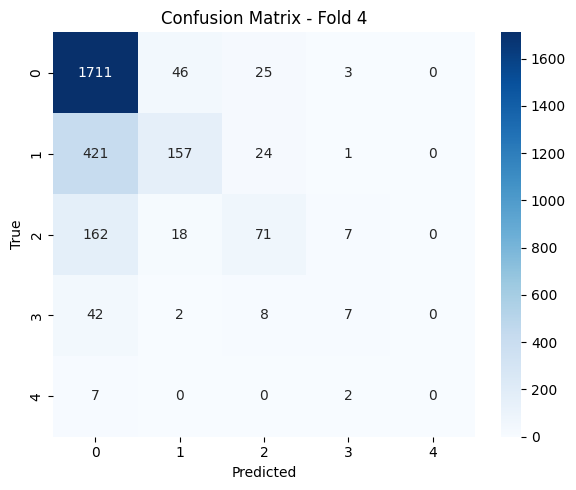

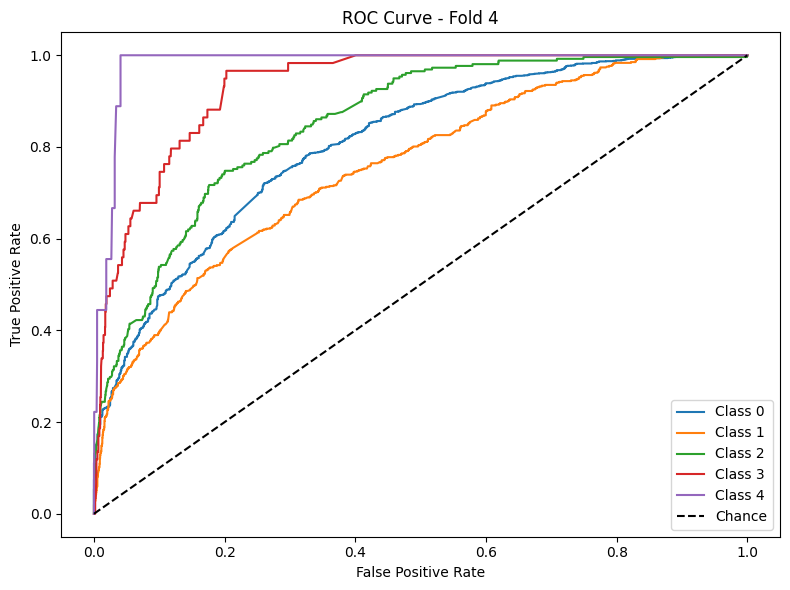

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 12s - 36ms/step - accuracy: 0.6558 - loss: 0.9954 - val_accuracy: 0.6577 - val_loss: 0.8499
Epoch 2/30
340/340 - 2s - 6ms/step - accuracy: 0.6575 - loss: 0.8518 - val_accuracy: 0.6606 - val_loss: 0.8226
Epoch 3/30
340/340 - 2s - 6ms/step - accuracy: 0.6606 - loss: 0.8263 - val_accuracy: 0.6780 - val_loss: 0.7988
Epoch 4/30
340/340 - 2s - 5ms/step - accuracy: 0.6721 - loss: 0.8028 - val_accuracy: 0.6783 - val_loss: 0.7814
Epoch 5/30
340/340 - 2s - 6ms/step - accuracy: 0.6772 - loss: 0.7941 - val_accuracy: 0.6898 - val_loss: 0.7724
Epoch 6/30
340/340 - 2s - 6ms/step - accuracy: 0.6785 - loss: 0.7868 - val_accuracy: 0.6875 - val_loss: 0.7691
Epoch 7/30
340/340 - 2s - 6ms/step - accuracy: 0.6802 - loss: 0.7745 - val_accuracy: 0.6931 - val_loss: 0.7583
Epoch 8/30
340/340 - 2s - 6ms/step - accuracy: 0.6887 - loss: 0.7672 - val_accuracy: 0.6971 - val_loss: 0.7506
Epoch 9/30
340/340 - 2s - 6ms/step - accuracy: 0.6885 - loss: 0.7662 - val_accuracy: 0.6982 - val_loss: 0.7499
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


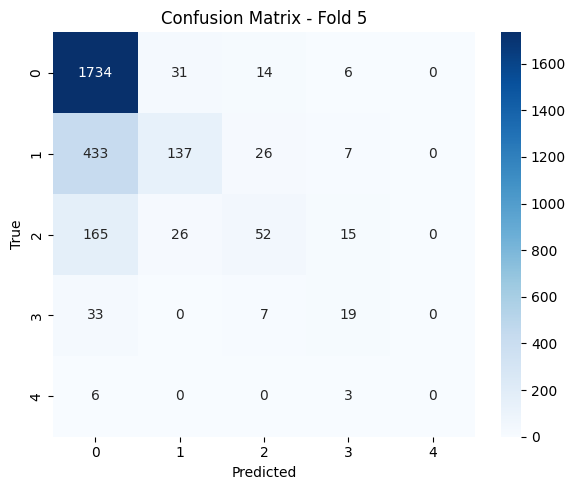

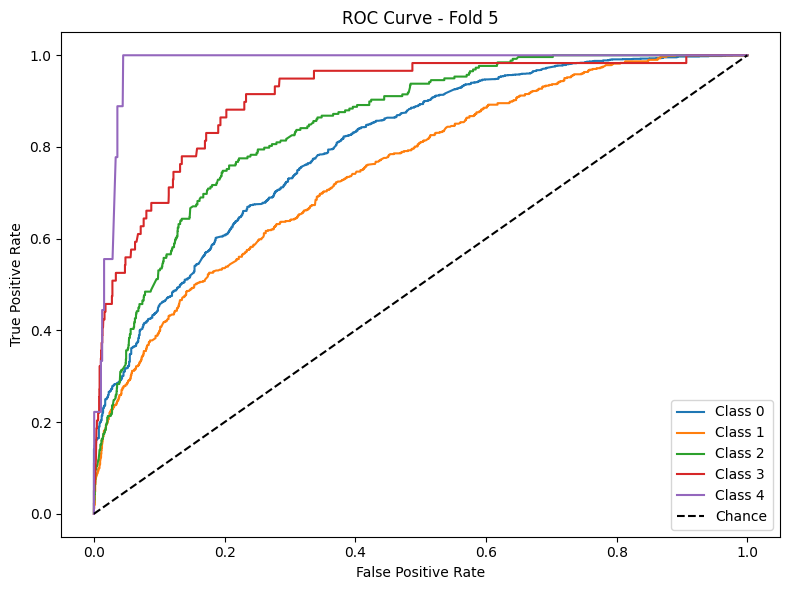


Average Accuracy: 0.7102
Average F1 Macro: 0.3569
Average AUC: 0.8530


======= Training Phase 2 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 12s - 42ms/step - accuracy: 0.6575 - loss: 1.0143 - val_accuracy: 0.6588 - val_loss: 0.8753
Epoch 2/30
283/283 - 2s - 6ms/step - accuracy: 0.6597 - loss: 0.8636 - val_accuracy: 0.6588 - val_loss: 0.8526
Epoch 3/30
283/283 - 2s - 6ms/step - accuracy: 0.6608 - loss: 0.8459 - val_accuracy: 0.6606 - val_loss: 0.8431
Epoch 4/30
283/283 - 2s - 6ms/step - accuracy: 0.6616 - loss: 0.8371 - val_accuracy: 0.6606 - val_loss: 0.8347
Epoch 5/30
283/283 - 2s - 6ms/step - accuracy: 0.6626 - loss: 0.8269 - val_accuracy: 0.6624 - val_loss: 0.8266
Epoch 6/30
283/283 - 2s - 6ms/step - accuracy: 0.6618 - loss: 0.8169 - val_accuracy: 0.6606 - val_loss: 0.8186
Epoch 7/30
283/283 - 2s - 6ms/step - accuracy: 0.6669 - loss: 0.8047 - val_accuracy: 0.6611 - val_loss: 0.8027
Epoch 8/30
283/283 - 2s - 6ms/step - accuracy: 0.6739 - loss: 0.7901 - val_accuracy: 0.6743 - val_loss: 0.7912
Epoch 9/30
283/283 - 2s - 6ms/step - accuracy: 0.6797 - loss: 0.7917 - val_accuracy: 0.6814 - val_loss: 0.7819
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


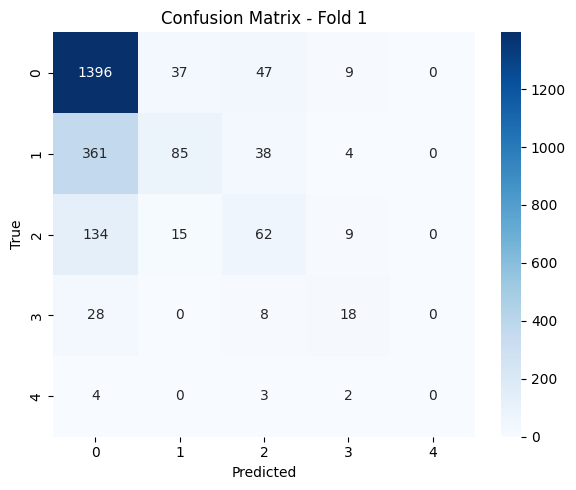

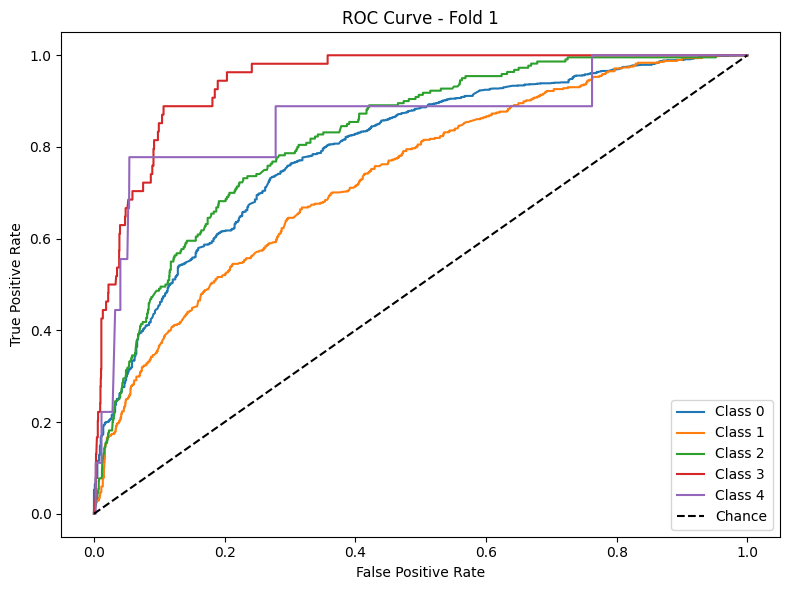

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 12s - 42ms/step - accuracy: 0.6567 - loss: 1.0214 - val_accuracy: 0.6588 - val_loss: 0.8670
Epoch 2/30
283/283 - 2s - 6ms/step - accuracy: 0.6596 - loss: 0.8671 - val_accuracy: 0.6597 - val_loss: 0.8344
Epoch 3/30
283/283 - 2s - 6ms/step - accuracy: 0.6602 - loss: 0.8537 - val_accuracy: 0.6588 - val_loss: 0.8229
Epoch 4/30
283/283 - 2s - 6ms/step - accuracy: 0.6606 - loss: 0.8399 - val_accuracy: 0.6646 - val_loss: 0.8124
Epoch 5/30
283/283 - 2s - 6ms/step - accuracy: 0.6623 - loss: 0.8295 - val_accuracy: 0.6619 - val_loss: 0.8004
Epoch 6/30
283/283 - 2s - 6ms/step - accuracy: 0.6619 - loss: 0.8179 - val_accuracy: 0.6619 - val_loss: 0.7899
Epoch 7/30
283/283 - 2s - 6ms/step - accuracy: 0.6685 - loss: 0.8059 - val_accuracy: 0.6850 - val_loss: 0.7733
Epoch 8/30
283/283 - 2s - 6ms/step - accuracy: 0.6758 - loss: 0.7844 - val_accuracy: 0.6827 - val_loss: 0.7695
Epoch 9/30
283/283 - 2s - 6ms/step - accuracy: 0.6775 - loss: 0.7832 - val_accuracy: 0.6823 - val_loss: 0.7631
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


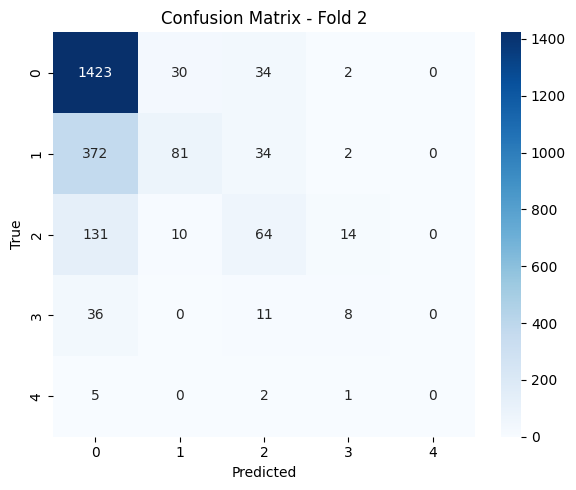

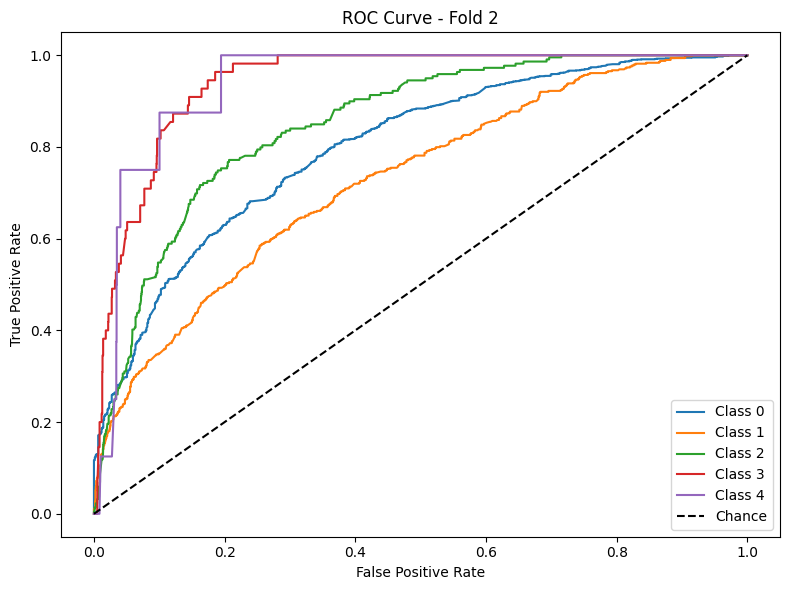

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 12s - 43ms/step - accuracy: 0.6569 - loss: 1.0124 - val_accuracy: 0.6591 - val_loss: 0.8640
Epoch 2/30
283/283 - 2s - 6ms/step - accuracy: 0.6591 - loss: 0.8612 - val_accuracy: 0.6591 - val_loss: 0.8442
Epoch 3/30
283/283 - 2s - 6ms/step - accuracy: 0.6594 - loss: 0.8440 - val_accuracy: 0.6591 - val_loss: 0.8330
Epoch 4/30
283/283 - 2s - 6ms/step - accuracy: 0.6620 - loss: 0.8198 - val_accuracy: 0.6605 - val_loss: 0.8249
Epoch 5/30
283/283 - 2s - 6ms/step - accuracy: 0.6705 - loss: 0.8076 - val_accuracy: 0.6715 - val_loss: 0.7961
Epoch 6/30
283/283 - 2s - 6ms/step - accuracy: 0.6737 - loss: 0.7969 - val_accuracy: 0.6760 - val_loss: 0.7936
Epoch 7/30
283/283 - 2s - 6ms/step - accuracy: 0.6809 - loss: 0.7882 - val_accuracy: 0.6702 - val_loss: 0.7992
Epoch 8/30
283/283 - 2s - 6ms/step - accuracy: 0.6813 - loss: 0.7776 - val_accuracy: 0.6742 - val_loss: 0.7860
Epoch 9/30
283/283 - 2s - 6ms/step - accuracy: 0.6848 - loss: 0.7698 - val_accuracy: 0.6720 - val_loss: 0.7865
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


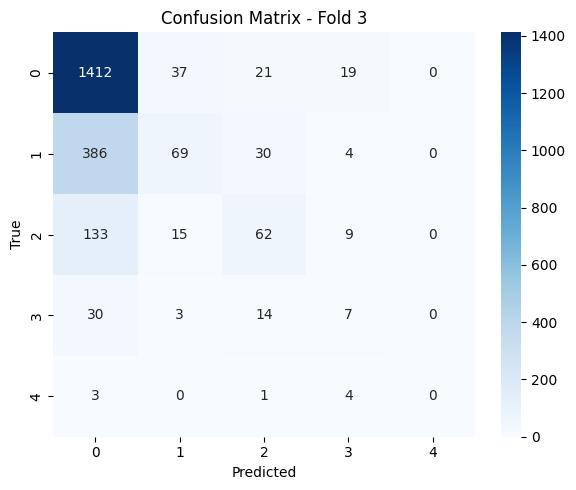

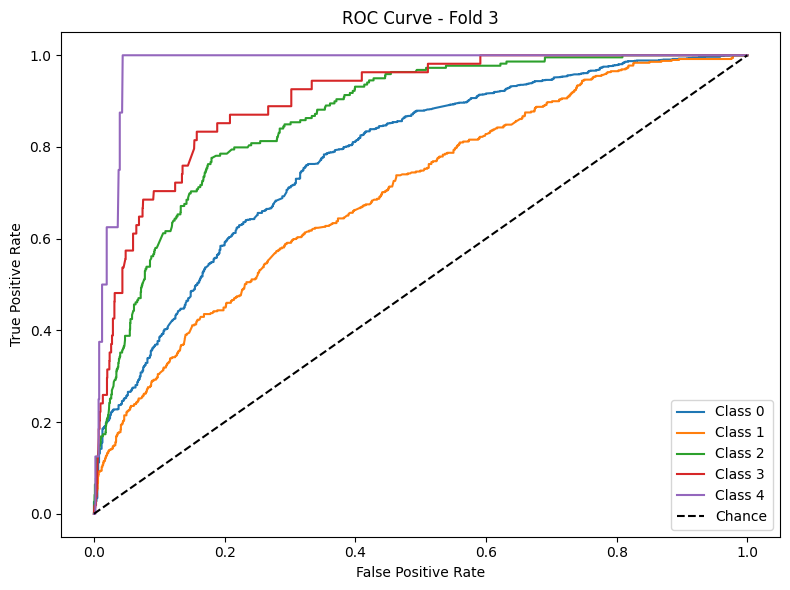

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 12s - 43ms/step - accuracy: 0.6567 - loss: 1.0164 - val_accuracy: 0.6591 - val_loss: 0.8670
Epoch 2/30
283/283 - 2s - 6ms/step - accuracy: 0.6600 - loss: 0.8619 - val_accuracy: 0.6591 - val_loss: 0.8437
Epoch 3/30
283/283 - 2s - 6ms/step - accuracy: 0.6613 - loss: 0.8415 - val_accuracy: 0.6600 - val_loss: 0.8314
Epoch 4/30
283/283 - 2s - 6ms/step - accuracy: 0.6613 - loss: 0.8318 - val_accuracy: 0.6556 - val_loss: 0.8234
Epoch 5/30
283/283 - 2s - 6ms/step - accuracy: 0.6639 - loss: 0.8181 - val_accuracy: 0.6609 - val_loss: 0.8176
Epoch 6/30
283/283 - 2s - 6ms/step - accuracy: 0.6706 - loss: 0.8033 - val_accuracy: 0.6764 - val_loss: 0.7958
Epoch 7/30
283/283 - 2s - 6ms/step - accuracy: 0.6747 - loss: 0.7925 - val_accuracy: 0.6751 - val_loss: 0.7855
Epoch 8/30
283/283 - 2s - 6ms/step - accuracy: 0.6786 - loss: 0.7823 - val_accuracy: 0.6813 - val_loss: 0.7755
Epoch 9/30
283/283 - 2s - 6ms/step - accuracy: 0.6821 - loss: 0.7770 - val_accuracy: 0.6755 - val_loss: 0.7771
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


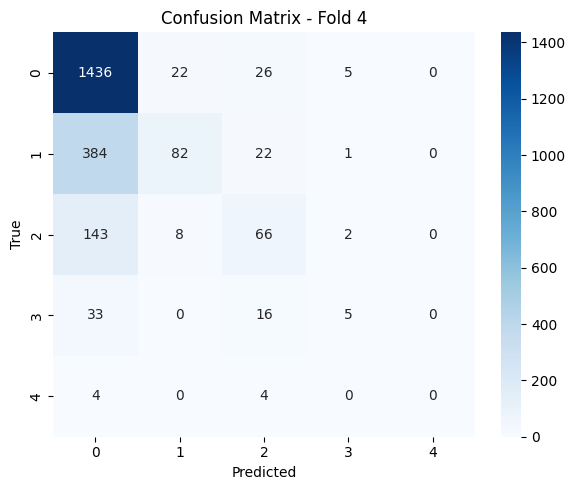

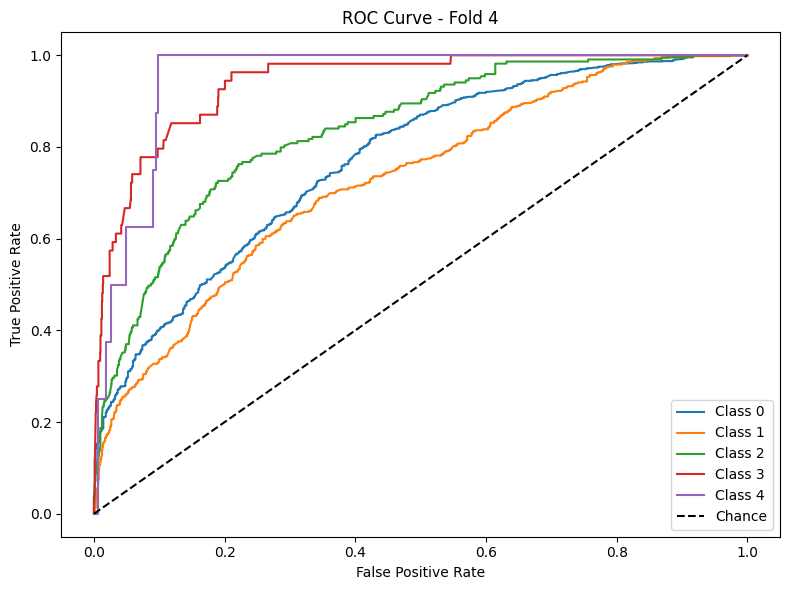

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 12s - 44ms/step - accuracy: 0.6571 - loss: 1.0245 - val_accuracy: 0.6596 - val_loss: 0.8639
Epoch 2/30
283/283 - 2s - 6ms/step - accuracy: 0.6595 - loss: 0.8702 - val_accuracy: 0.6591 - val_loss: 0.8363
Epoch 3/30
283/283 - 2s - 6ms/step - accuracy: 0.6599 - loss: 0.8507 - val_accuracy: 0.6591 - val_loss: 0.8234
Epoch 4/30
283/283 - 2s - 5ms/step - accuracy: 0.6615 - loss: 0.8356 - val_accuracy: 0.6600 - val_loss: 0.8165
Epoch 5/30
283/283 - 2s - 5ms/step - accuracy: 0.6623 - loss: 0.8246 - val_accuracy: 0.6609 - val_loss: 0.8078
Epoch 6/30
283/283 - 2s - 5ms/step - accuracy: 0.6659 - loss: 0.8089 - val_accuracy: 0.6662 - val_loss: 0.8034
Epoch 7/30
283/283 - 2s - 6ms/step - accuracy: 0.6728 - loss: 0.8003 - val_accuracy: 0.6791 - val_loss: 0.7863
Epoch 8/30
283/283 - 2s - 6ms/step - accuracy: 0.6763 - loss: 0.7886 - val_accuracy: 0.6817 - val_loss: 0.7797
Epoch 9/30
283/283 - 2s - 6ms/step - accuracy: 0.6773 - loss: 0.7796 - val_accuracy: 0.6848 - val_loss: 0.7744
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


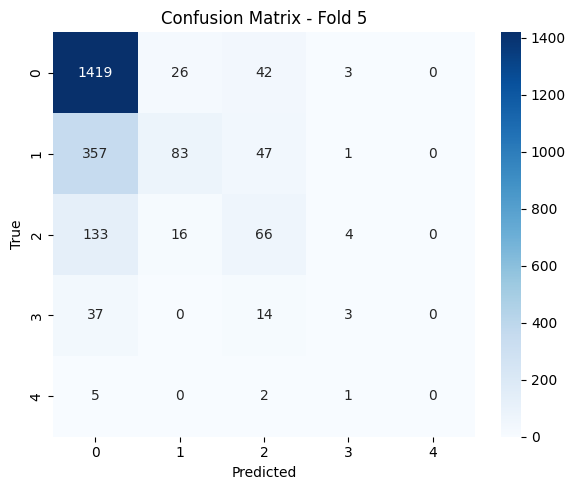

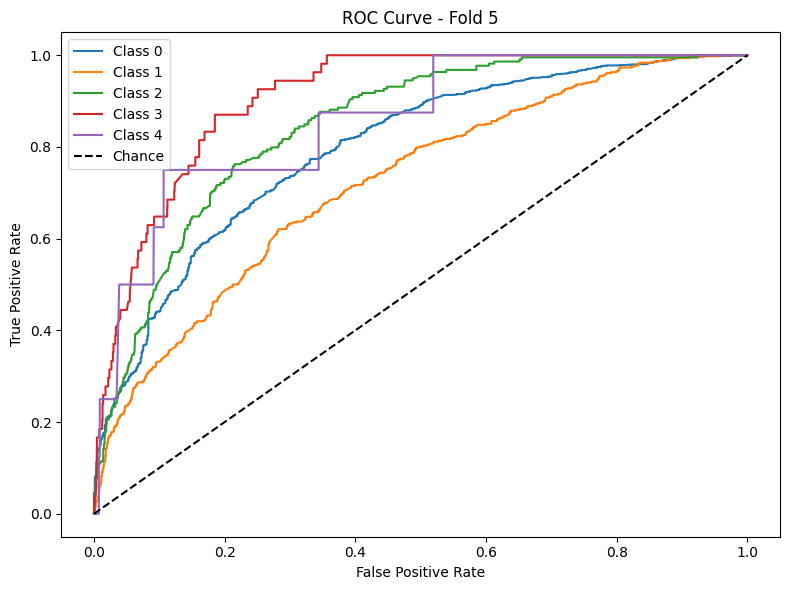


Average Accuracy: 0.6946
Average F1 Macro: 0.3247
Average AUC: 0.8403


======= Training Phase 3 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 12s - 48ms/step - accuracy: 0.6542 - loss: 1.0389 - val_accuracy: 0.6562 - val_loss: 0.8777
Epoch 2/30
260/260 - 2s - 6ms/step - accuracy: 0.6559 - loss: 0.8750 - val_accuracy: 0.6620 - val_loss: 0.8463
Epoch 3/30
260/260 - 1s - 6ms/step - accuracy: 0.6573 - loss: 0.8539 - val_accuracy: 0.6577 - val_loss: 0.8304
Epoch 4/30
260/260 - 1s - 6ms/step - accuracy: 0.6576 - loss: 0.8393 - val_accuracy: 0.6644 - val_loss: 0.8185
Epoch 5/30
260/260 - 2s - 6ms/step - accuracy: 0.6588 - loss: 0.8243 - val_accuracy: 0.6577 - val_loss: 0.8090
Epoch 6/30
260/260 - 2s - 6ms/step - accuracy: 0.6635 - loss: 0.8115 - val_accuracy: 0.6716 - val_loss: 0.7929
Epoch 7/30
260/260 - 1s - 6ms/step - accuracy: 0.6719 - loss: 0.7974 - val_accuracy: 0.6808 - val_loss: 0.7700
Epoch 8/30
260/260 - 1s - 6ms/step - accuracy: 0.6728 - loss: 0.7857 - val_accuracy: 0.6823 - val_loss: 0.7622
Epoch 9/30
260/260 - 2s - 6ms/step - accuracy: 0.6797 - loss: 0.7749 - val_accuracy: 0.6866 - val_loss: 0.7590
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


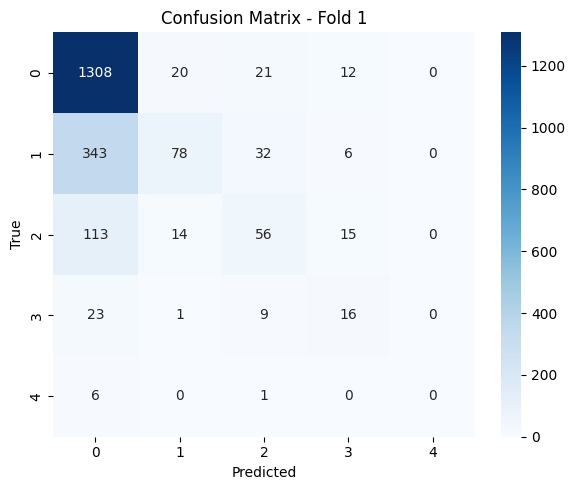

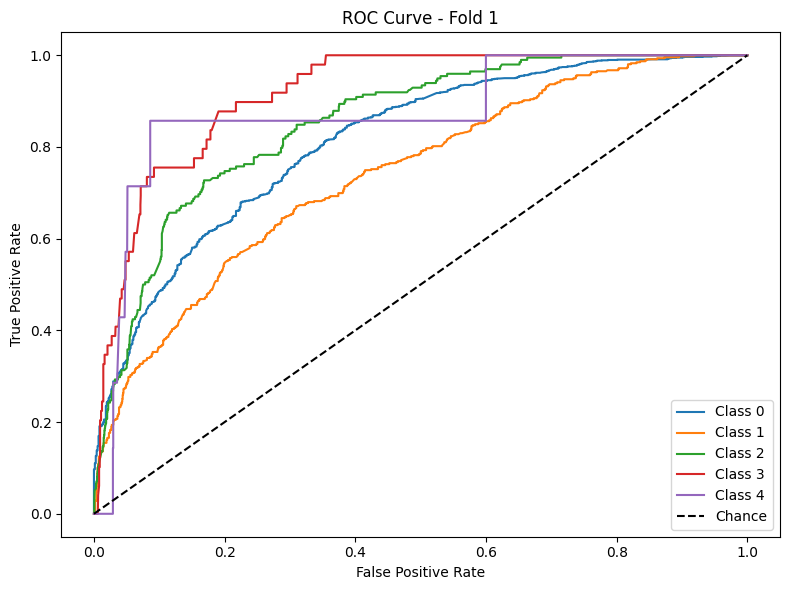

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 12s - 47ms/step - accuracy: 0.6539 - loss: 1.0465 - val_accuracy: 0.6557 - val_loss: 0.8668
Epoch 2/30
260/260 - 1s - 6ms/step - accuracy: 0.6557 - loss: 0.8739 - val_accuracy: 0.6557 - val_loss: 0.8462
Epoch 3/30
260/260 - 1s - 6ms/step - accuracy: 0.6568 - loss: 0.8504 - val_accuracy: 0.6557 - val_loss: 0.8262
Epoch 4/30
260/260 - 2s - 6ms/step - accuracy: 0.6576 - loss: 0.8340 - val_accuracy: 0.6581 - val_loss: 0.8208
Epoch 5/30
260/260 - 1s - 6ms/step - accuracy: 0.6590 - loss: 0.8250 - val_accuracy: 0.6567 - val_loss: 0.8105
Epoch 6/30
260/260 - 1s - 6ms/step - accuracy: 0.6626 - loss: 0.8086 - val_accuracy: 0.6707 - val_loss: 0.8006
Epoch 7/30
260/260 - 1s - 6ms/step - accuracy: 0.6750 - loss: 0.7927 - val_accuracy: 0.6789 - val_loss: 0.7842
Epoch 8/30
260/260 - 1s - 6ms/step - accuracy: 0.6802 - loss: 0.7788 - val_accuracy: 0.6803 - val_loss: 0.7819
Epoch 9/30
260/260 - 1s - 6ms/step - accuracy: 0.6861 - loss: 0.7711 - val_accuracy: 0.6914 - val_loss: 0.7679
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


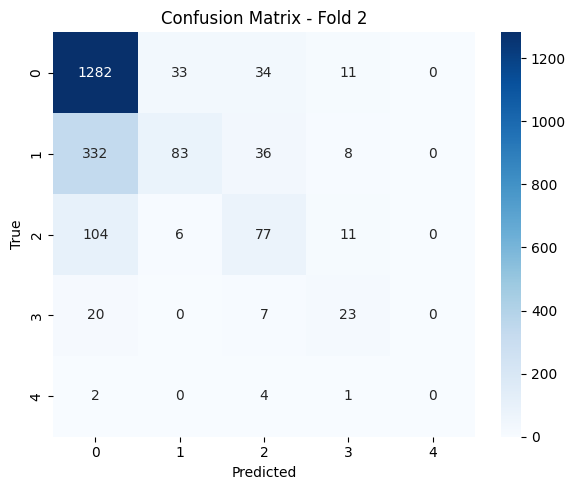

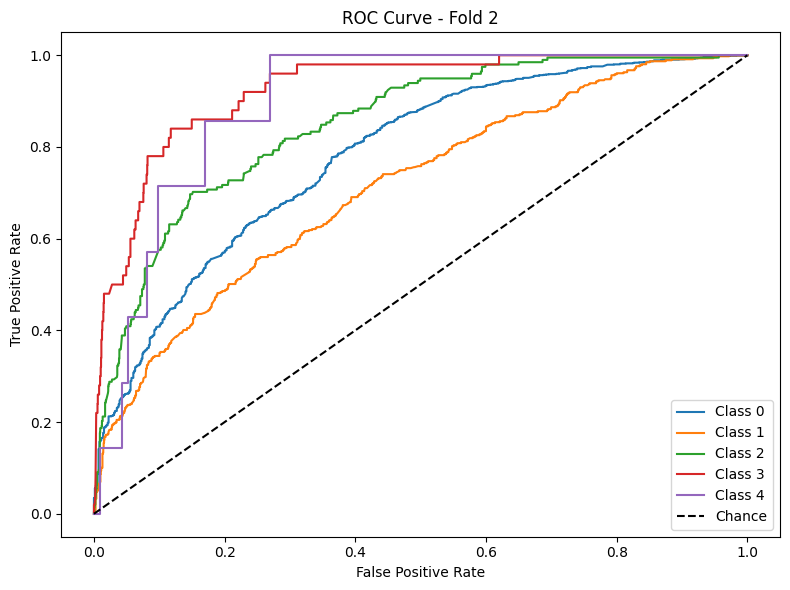

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 11s - 43ms/step - accuracy: 0.6540 - loss: 1.0321 - val_accuracy: 0.6553 - val_loss: 0.8773
Epoch 2/30
260/260 - 1s - 6ms/step - accuracy: 0.6558 - loss: 0.8764 - val_accuracy: 0.6553 - val_loss: 0.8497
Epoch 3/30
260/260 - 1s - 6ms/step - accuracy: 0.6565 - loss: 0.8503 - val_accuracy: 0.6581 - val_loss: 0.8322
Epoch 4/30
260/260 - 1s - 6ms/step - accuracy: 0.6577 - loss: 0.8324 - val_accuracy: 0.6572 - val_loss: 0.8218
Epoch 5/30
260/260 - 1s - 6ms/step - accuracy: 0.6581 - loss: 0.8219 - val_accuracy: 0.6572 - val_loss: 0.8161
Epoch 6/30
260/260 - 2s - 6ms/step - accuracy: 0.6588 - loss: 0.8179 - val_accuracy: 0.6606 - val_loss: 0.8170
Epoch 7/30
260/260 - 2s - 6ms/step - accuracy: 0.6588 - loss: 0.8053 - val_accuracy: 0.6601 - val_loss: 0.8133
Epoch 8/30
260/260 - 1s - 6ms/step - accuracy: 0.6655 - loss: 0.7962 - val_accuracy: 0.6784 - val_loss: 0.7914
Epoch 9/30
260/260 - 1s - 6ms/step - accuracy: 0.6739 - loss: 0.7838 - val_accuracy: 0.6774 - val_loss: 0.7858
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


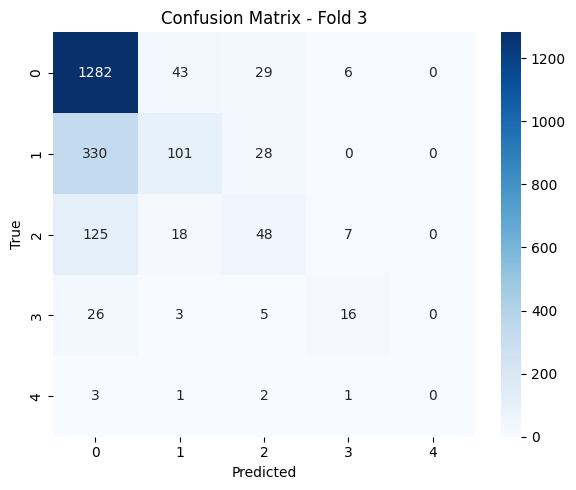

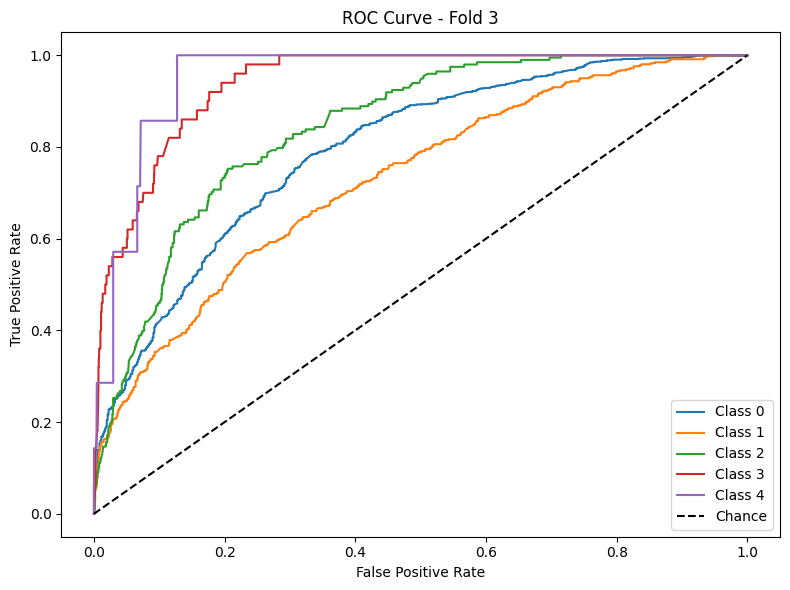

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 13s - 49ms/step - accuracy: 0.6533 - loss: 1.0406 - val_accuracy: 0.6557 - val_loss: 0.8743
Epoch 2/30
260/260 - 1s - 6ms/step - accuracy: 0.6558 - loss: 0.8722 - val_accuracy: 0.6557 - val_loss: 0.8489
Epoch 3/30
260/260 - 1s - 6ms/step - accuracy: 0.6577 - loss: 0.8454 - val_accuracy: 0.6567 - val_loss: 0.8384
Epoch 4/30
260/260 - 1s - 6ms/step - accuracy: 0.6588 - loss: 0.8325 - val_accuracy: 0.6562 - val_loss: 0.8326
Epoch 5/30
260/260 - 1s - 6ms/step - accuracy: 0.6593 - loss: 0.8223 - val_accuracy: 0.6572 - val_loss: 0.8242
Epoch 6/30
260/260 - 1s - 6ms/step - accuracy: 0.6587 - loss: 0.8076 - val_accuracy: 0.6557 - val_loss: 0.8132
Epoch 7/30
260/260 - 1s - 6ms/step - accuracy: 0.6682 - loss: 0.7960 - val_accuracy: 0.6721 - val_loss: 0.8040
Epoch 8/30
260/260 - 1s - 6ms/step - accuracy: 0.6764 - loss: 0.7816 - val_accuracy: 0.6688 - val_loss: 0.7941
Epoch 9/30
260/260 - 1s - 6ms/step - accuracy: 0.6827 - loss: 0.7694 - val_accuracy: 0.6770 - val_loss: 0.7923
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


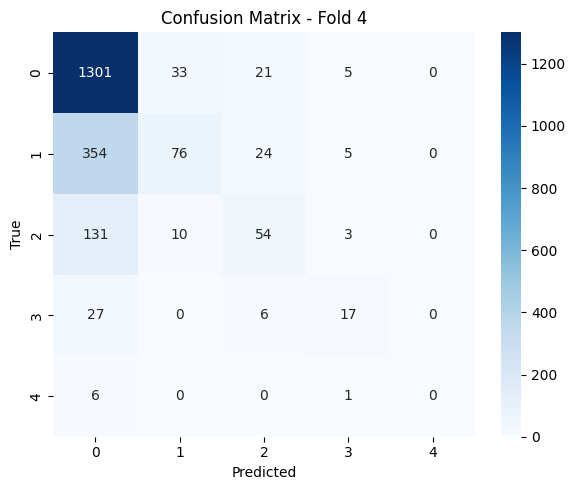

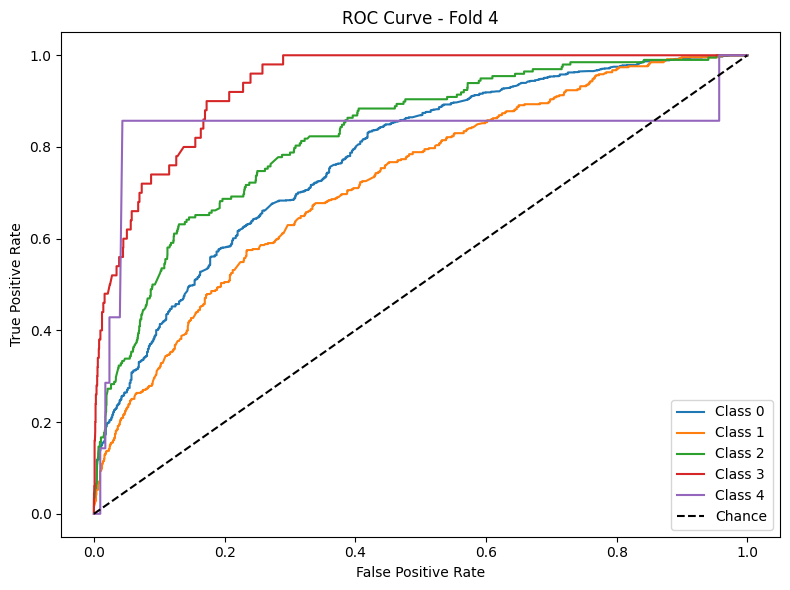

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 13s - 48ms/step - accuracy: 0.6539 - loss: 1.0380 - val_accuracy: 0.6561 - val_loss: 0.8852
Epoch 2/30
260/260 - 1s - 6ms/step - accuracy: 0.6563 - loss: 0.8701 - val_accuracy: 0.6551 - val_loss: 0.8590
Epoch 3/30
260/260 - 1s - 6ms/step - accuracy: 0.6581 - loss: 0.8507 - val_accuracy: 0.6570 - val_loss: 0.8359
Epoch 4/30
260/260 - 1s - 6ms/step - accuracy: 0.6594 - loss: 0.8354 - val_accuracy: 0.6551 - val_loss: 0.8263
Epoch 5/30
260/260 - 1s - 6ms/step - accuracy: 0.6612 - loss: 0.8162 - val_accuracy: 0.6570 - val_loss: 0.8149
Epoch 6/30
260/260 - 1s - 6ms/step - accuracy: 0.6716 - loss: 0.8019 - val_accuracy: 0.6681 - val_loss: 0.7951
Epoch 7/30
260/260 - 1s - 6ms/step - accuracy: 0.6784 - loss: 0.7825 - val_accuracy: 0.6773 - val_loss: 0.7897
Epoch 8/30
260/260 - 2s - 6ms/step - accuracy: 0.6827 - loss: 0.7727 - val_accuracy: 0.6705 - val_loss: 0.7866
Epoch 9/30
260/260 - 2s - 6ms/step - accuracy: 0.6905 - loss: 0.7600 - val_accuracy: 0.6869 - val_loss: 0.7803
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


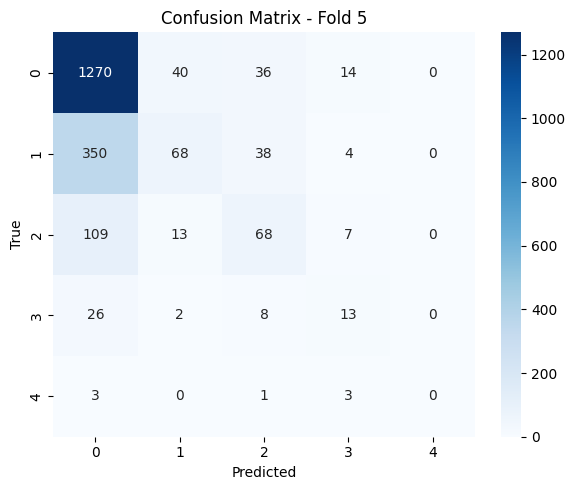

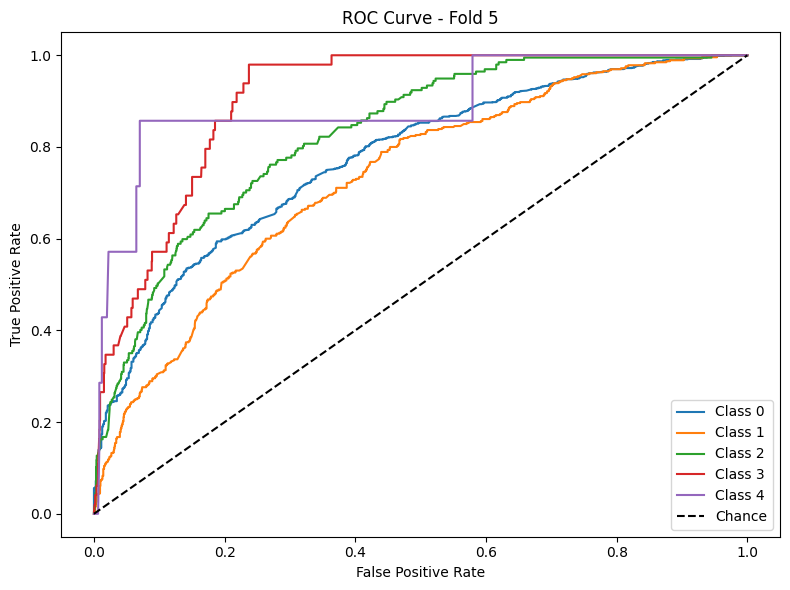


Average Accuracy: 0.6979
Average F1 Macro: 0.3683
Average AUC: 0.8341


======= Training Phase 4 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 11s - 58ms/step - accuracy: 0.6461 - loss: 1.0918 - val_accuracy: 0.6498 - val_loss: 0.9037
Epoch 2/30
193/193 - 1s - 6ms/step - accuracy: 0.6495 - loss: 0.8938 - val_accuracy: 0.6478 - val_loss: 0.8751
Epoch 3/30
193/193 - 1s - 6ms/step - accuracy: 0.6508 - loss: 0.8705 - val_accuracy: 0.6498 - val_loss: 0.8497
Epoch 4/30
193/193 - 1s - 6ms/step - accuracy: 0.6510 - loss: 0.8487 - val_accuracy: 0.6511 - val_loss: 0.8373
Epoch 5/30
193/193 - 1s - 6ms/step - accuracy: 0.6560 - loss: 0.8256 - val_accuracy: 0.6595 - val_loss: 0.8113
Epoch 6/30
193/193 - 1s - 6ms/step - accuracy: 0.6696 - loss: 0.8024 - val_accuracy: 0.6725 - val_loss: 0.7809
Epoch 7/30
193/193 - 1s - 6ms/step - accuracy: 0.6766 - loss: 0.7843 - val_accuracy: 0.6771 - val_loss: 0.7717
Epoch 8/30
193/193 - 1s - 6ms/step - accuracy: 0.6882 - loss: 0.7719 - val_accuracy: 0.6836 - val_loss: 0.7641
Epoch 9/30
193/193 - 1s - 6ms/step - accuracy: 0.6867 - loss: 0.7594 - val_accuracy: 0.6758 - val_loss: 0.7714
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


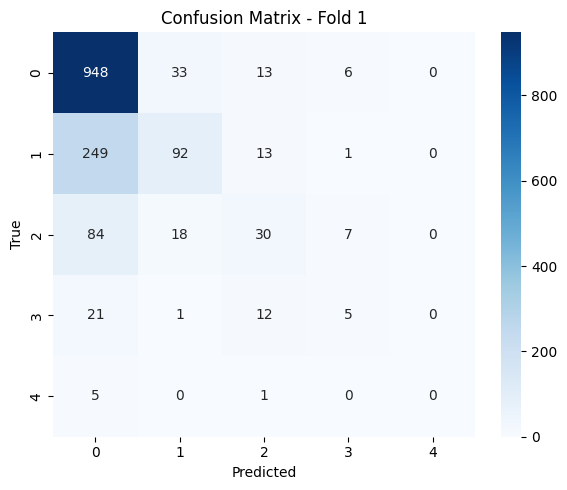

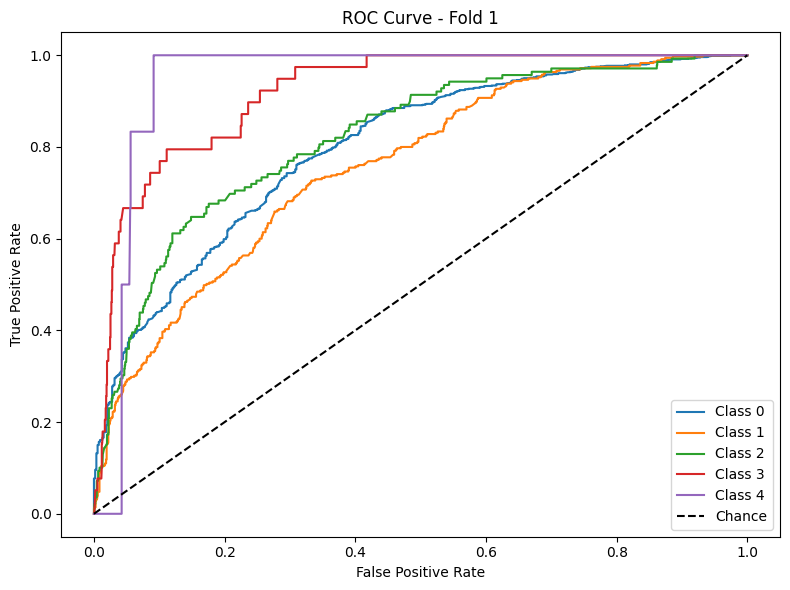

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 13s - 66ms/step - accuracy: 0.6462 - loss: 1.0901 - val_accuracy: 0.6498 - val_loss: 0.8939
Epoch 2/30
193/193 - 1s - 6ms/step - accuracy: 0.6498 - loss: 0.8835 - val_accuracy: 0.6504 - val_loss: 0.8592
Epoch 3/30
193/193 - 1s - 6ms/step - accuracy: 0.6503 - loss: 0.8523 - val_accuracy: 0.6530 - val_loss: 0.8553
Epoch 4/30
193/193 - 1s - 6ms/step - accuracy: 0.6576 - loss: 0.8243 - val_accuracy: 0.6673 - val_loss: 0.8272
Epoch 5/30
193/193 - 1s - 6ms/step - accuracy: 0.6661 - loss: 0.8066 - val_accuracy: 0.6660 - val_loss: 0.8063
Epoch 6/30
193/193 - 1s - 6ms/step - accuracy: 0.6722 - loss: 0.7859 - val_accuracy: 0.6738 - val_loss: 0.8010
Epoch 7/30
193/193 - 1s - 6ms/step - accuracy: 0.6818 - loss: 0.7720 - val_accuracy: 0.6706 - val_loss: 0.7899
Epoch 8/30
193/193 - 1s - 6ms/step - accuracy: 0.6771 - loss: 0.7637 - val_accuracy: 0.6719 - val_loss: 0.7746
Epoch 9/30
193/193 - 1s - 6ms/step - accuracy: 0.6838 - loss: 0.7533 - val_accuracy: 0.6745 - val_loss: 0.7753
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


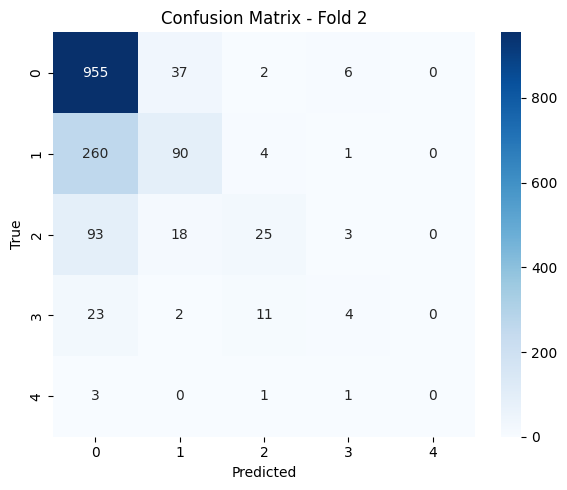

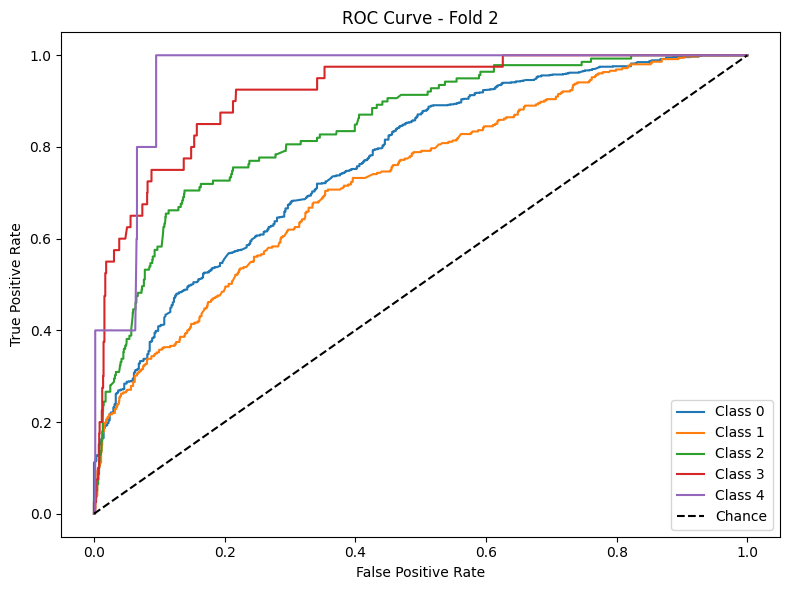

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 11s - 57ms/step - accuracy: 0.6477 - loss: 1.1048 - val_accuracy: 0.6491 - val_loss: 0.9004
Epoch 2/30
193/193 - 1s - 6ms/step - accuracy: 0.6495 - loss: 0.8843 - val_accuracy: 0.6491 - val_loss: 0.8715
Epoch 3/30
193/193 - 1s - 6ms/step - accuracy: 0.6495 - loss: 0.8560 - val_accuracy: 0.6537 - val_loss: 0.8489
Epoch 4/30
193/193 - 1s - 6ms/step - accuracy: 0.6519 - loss: 0.8355 - val_accuracy: 0.6563 - val_loss: 0.8399
Epoch 5/30
193/193 - 1s - 6ms/step - accuracy: 0.6566 - loss: 0.8185 - val_accuracy: 0.6628 - val_loss: 0.8177
Epoch 6/30
193/193 - 1s - 6ms/step - accuracy: 0.6744 - loss: 0.7971 - val_accuracy: 0.6784 - val_loss: 0.7993
Epoch 7/30
193/193 - 1s - 6ms/step - accuracy: 0.6807 - loss: 0.7861 - val_accuracy: 0.6816 - val_loss: 0.7911
Epoch 8/30
193/193 - 1s - 6ms/step - accuracy: 0.6813 - loss: 0.7739 - val_accuracy: 0.6829 - val_loss: 0.7737
Epoch 9/30
193/193 - 1s - 6ms/step - accuracy: 0.6943 - loss: 0.7581 - val_accuracy: 0.6875 - val_loss: 0.7742
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


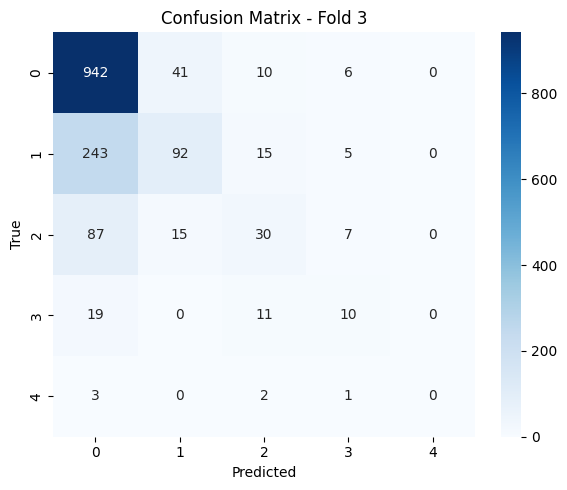

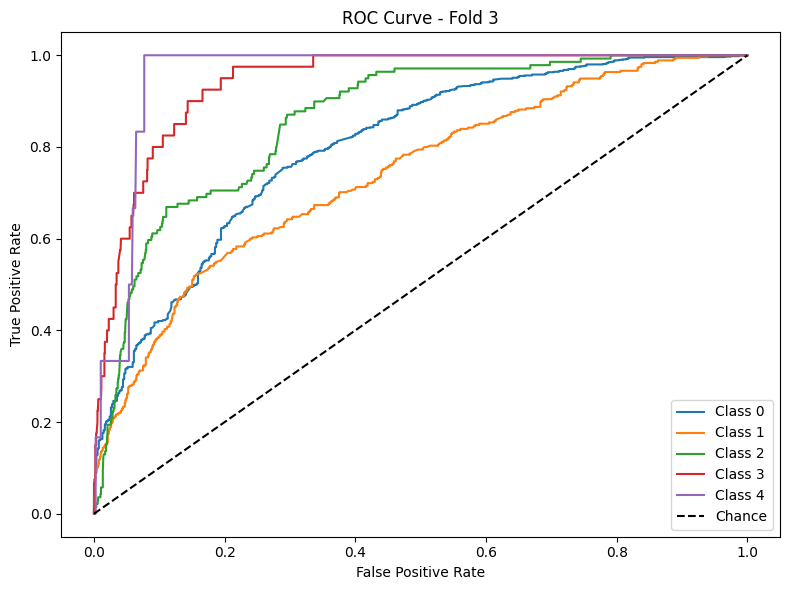

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 13s - 67ms/step - accuracy: 0.6474 - loss: 1.1036 - val_accuracy: 0.6495 - val_loss: 0.8950
Epoch 2/30
193/193 - 1s - 6ms/step - accuracy: 0.6492 - loss: 0.8952 - val_accuracy: 0.6495 - val_loss: 0.8596
Epoch 3/30
193/193 - 1s - 6ms/step - accuracy: 0.6510 - loss: 0.8627 - val_accuracy: 0.6508 - val_loss: 0.8329
Epoch 4/30
193/193 - 1s - 6ms/step - accuracy: 0.6510 - loss: 0.8420 - val_accuracy: 0.6515 - val_loss: 0.8307
Epoch 5/30
193/193 - 1s - 6ms/step - accuracy: 0.6609 - loss: 0.8194 - val_accuracy: 0.6749 - val_loss: 0.7914
Epoch 6/30
193/193 - 1s - 7ms/step - accuracy: 0.6778 - loss: 0.7843 - val_accuracy: 0.6769 - val_loss: 0.7827
Epoch 7/30
193/193 - 1s - 7ms/step - accuracy: 0.6746 - loss: 0.7801 - val_accuracy: 0.6827 - val_loss: 0.7718
Epoch 8/30
193/193 - 1s - 7ms/step - accuracy: 0.6877 - loss: 0.7645 - val_accuracy: 0.6879 - val_loss: 0.7695
Epoch 9/30
193/193 - 1s - 7ms/step - accuracy: 0.6858 - loss: 0.7547 - val_accuracy: 0.6873 - val_loss: 0.7689
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


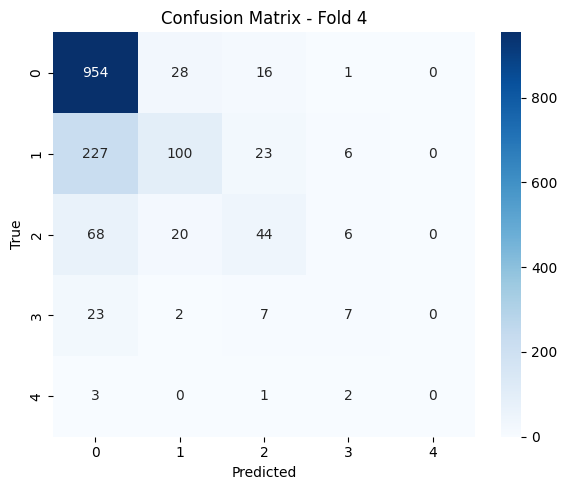

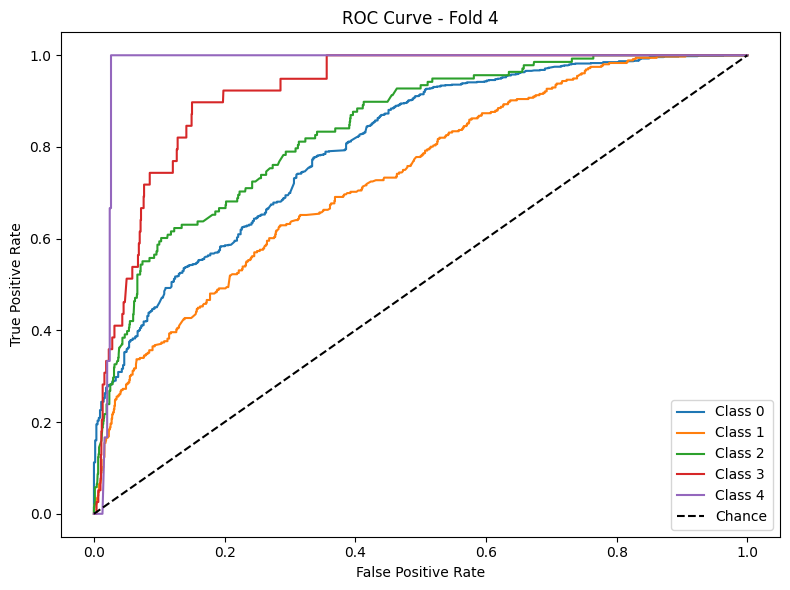

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 11s - 58ms/step - accuracy: 0.6465 - loss: 1.0946 - val_accuracy: 0.6495 - val_loss: 0.8909
Epoch 2/30
193/193 - 1s - 7ms/step - accuracy: 0.6492 - loss: 0.8888 - val_accuracy: 0.6482 - val_loss: 0.8605
Epoch 3/30
193/193 - 1s - 6ms/step - accuracy: 0.6492 - loss: 0.8625 - val_accuracy: 0.6495 - val_loss: 0.8376
Epoch 4/30
193/193 - 1s - 6ms/step - accuracy: 0.6513 - loss: 0.8404 - val_accuracy: 0.6534 - val_loss: 0.8177
Epoch 5/30
193/193 - 1s - 7ms/step - accuracy: 0.6671 - loss: 0.8144 - val_accuracy: 0.6827 - val_loss: 0.8018
Epoch 6/30
193/193 - 1s - 6ms/step - accuracy: 0.6695 - loss: 0.7957 - val_accuracy: 0.6931 - val_loss: 0.7778
Epoch 7/30
193/193 - 1s - 6ms/step - accuracy: 0.6809 - loss: 0.7794 - val_accuracy: 0.6905 - val_loss: 0.7788
Epoch 8/30
193/193 - 1s - 6ms/step - accuracy: 0.6837 - loss: 0.7633 - val_accuracy: 0.6873 - val_loss: 0.7713
Epoch 9/30
193/193 - 1s - 6ms/step - accuracy: 0.6920 - loss: 0.7554 - val_accuracy: 0.6840 - val_loss: 0.7596
Epoch 10/3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


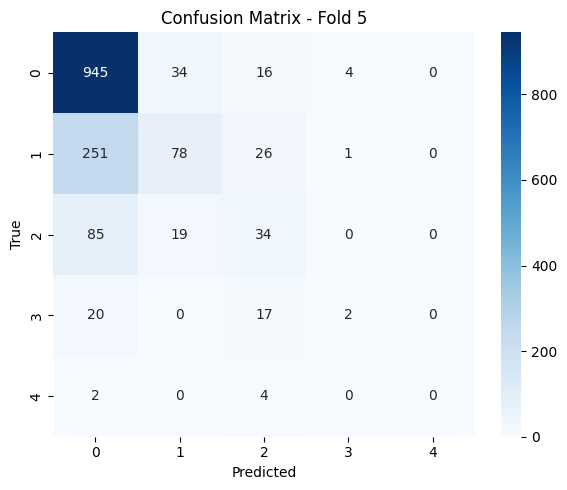

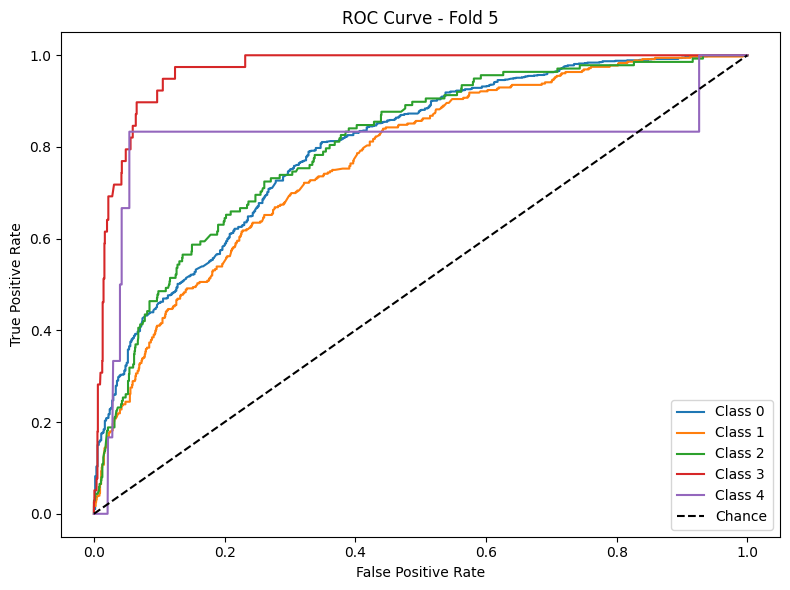


Average Accuracy: 0.7002
Average F1 Macro: 0.3353
Average AUC: 0.8474


In [5]:
# phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
# results = {}

# for i, phase_path in enumerate(phase_paths, start=1):
#     print(f"\n===================================")
#     print(f"\n======= Training Phase {i} ========")
#     print(f"\n===================================")
#     sample = False
#     model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
#     # Save best model & scaler
#     if sample: 
#         temp = "sample"
#     else: temp = "no_sample"
#     joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
#     joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
#     results[f"phase{i}"] = metrics


phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # ✅ Lưu mô hình LSTM bằng Keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # ✅ Lưu scaler bằng joblib (vẫn đúng)
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = load_model(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded'].values
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Reshape for LSTM (samples, timesteps=1, features)
    X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

    # Predict
    y_proba = model.predict(X_test_lstm)
    y_pred = np.argmax(y_proba, axis=1)

    # Extract classes from y_test (sorted and unique)
    classes = np.unique(np.concatenate((y_test, y_pred)))

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, labels=classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       568
           1       0.31      0.27      0.29        63
           2       0.21      0.07      0.11        43
           3       0.50      0.07      0.12        15
           4       0.00      0.00      0.00         9

    accuracy                           0.81       698
   macro avg       0.38      0.27      0.29       698
weighted avg       0.76      0.81      0.78       698



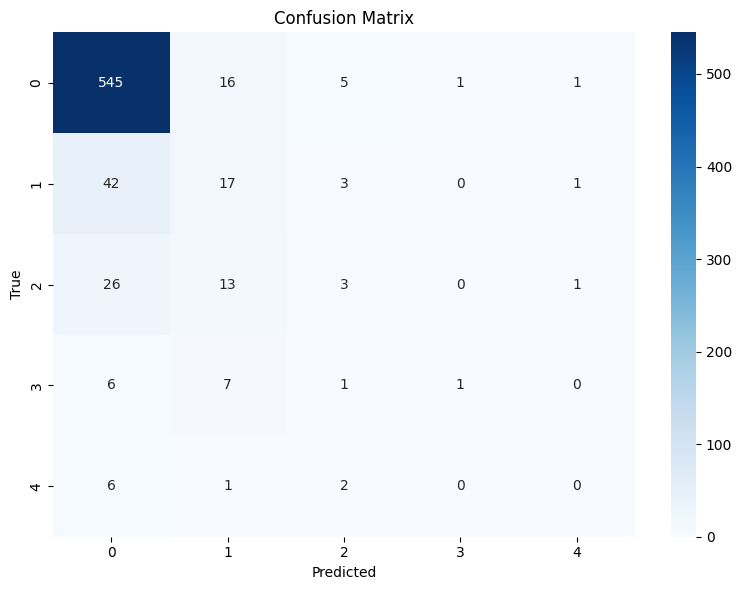


Test AUC (macro-average, OVR): 0.6827


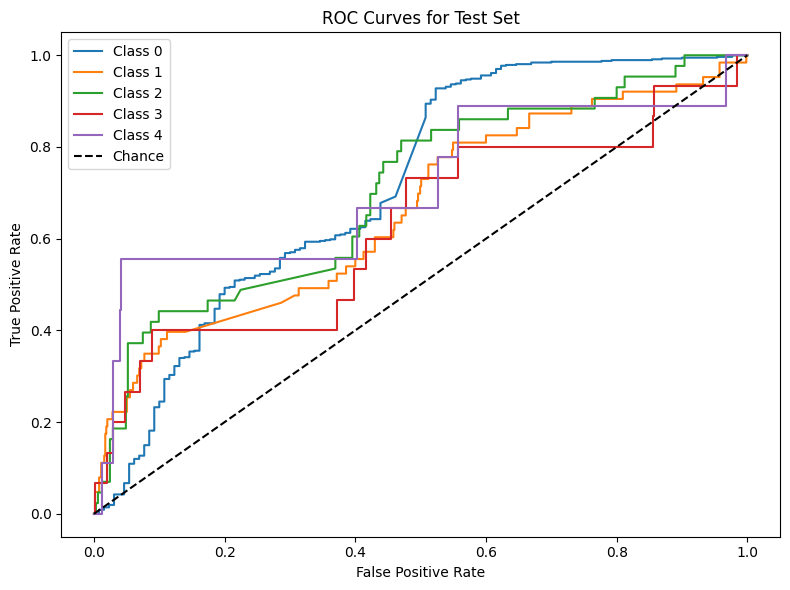

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       544
           1       0.31      0.27      0.29        59
           2       0.50      0.14      0.22        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.34      0.28      0.28       668
weighted avg       0.77      0.82      0.78       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


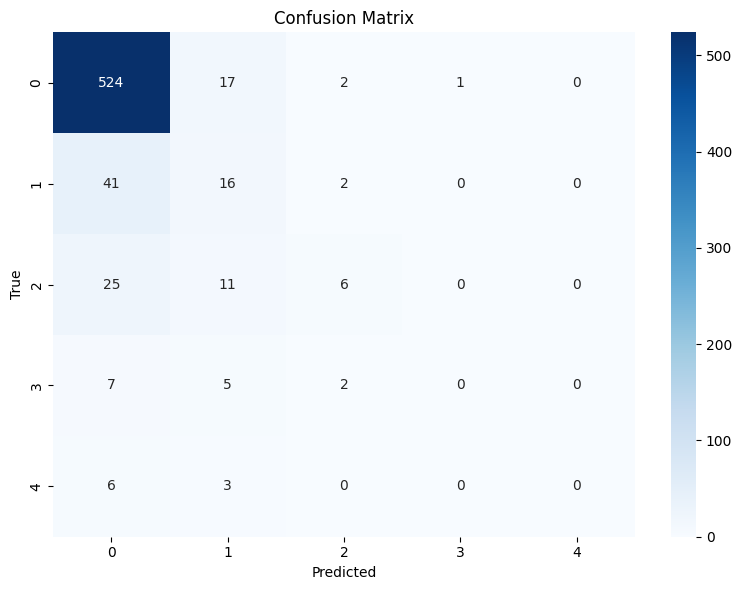


Test AUC (macro-average, OVR): 0.7329


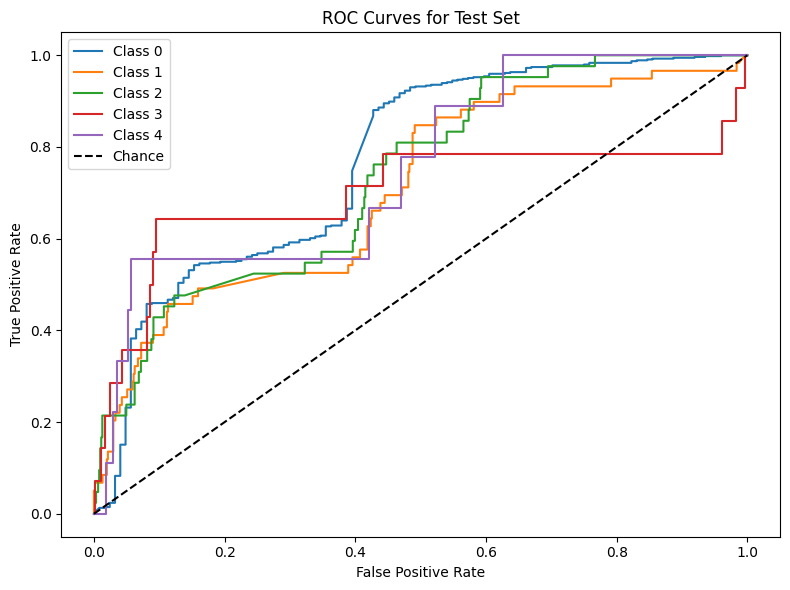

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       455
           1       0.41      0.33      0.37        52
           2       0.24      0.21      0.22        29
           3       1.00      0.10      0.18        10
           4       0.00      0.00      0.00         8

    accuracy                           0.83       554
   macro avg       0.51      0.32      0.34       554
weighted avg       0.80      0.83      0.81       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


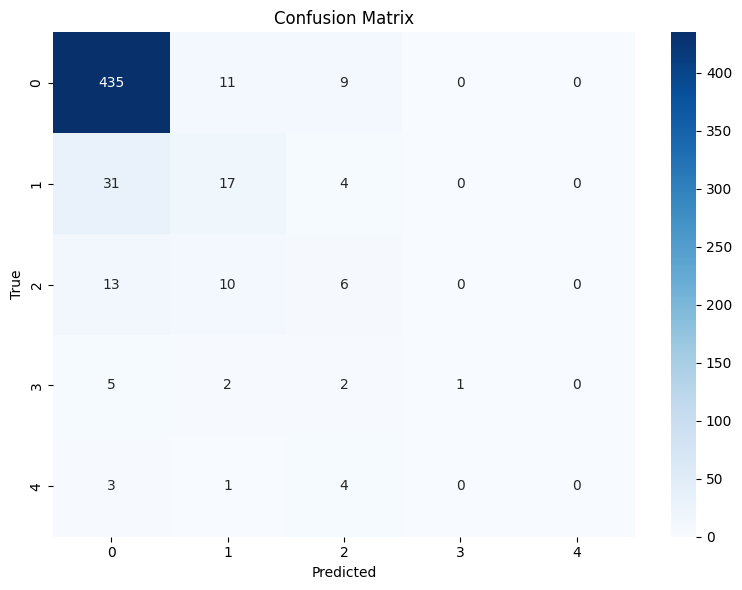


Test AUC (macro-average, OVR): 0.7356


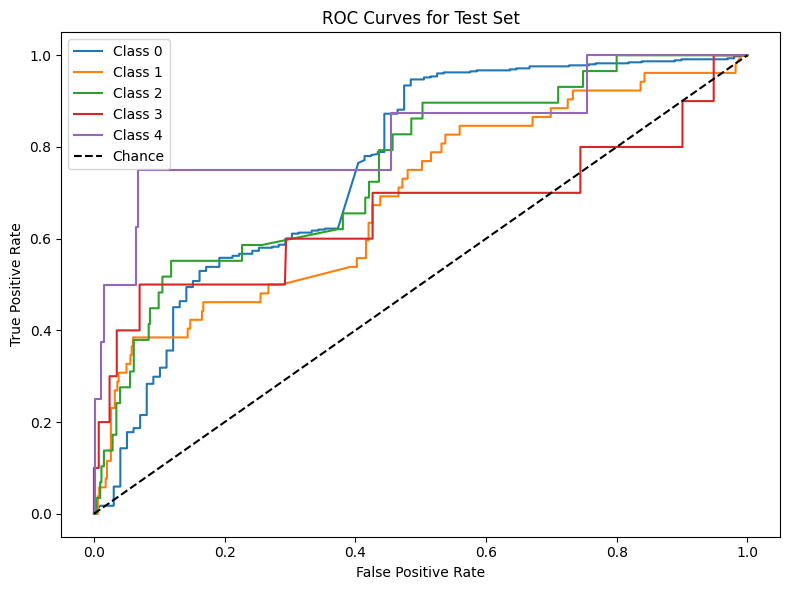

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       395
           1       0.24      0.23      0.23        40
           2       0.29      0.29      0.29        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.28      0.29      0.29       477
weighted avg       0.77      0.81      0.79       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


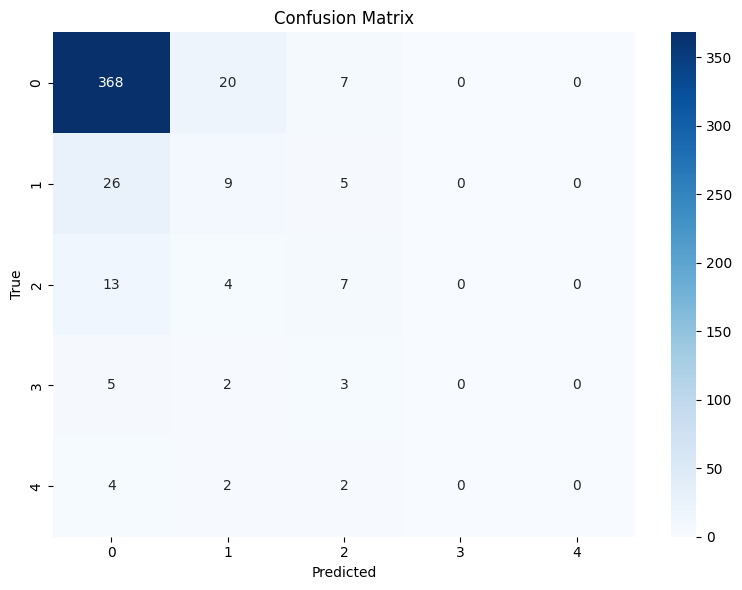


Test AUC (macro-average, OVR): 0.6694


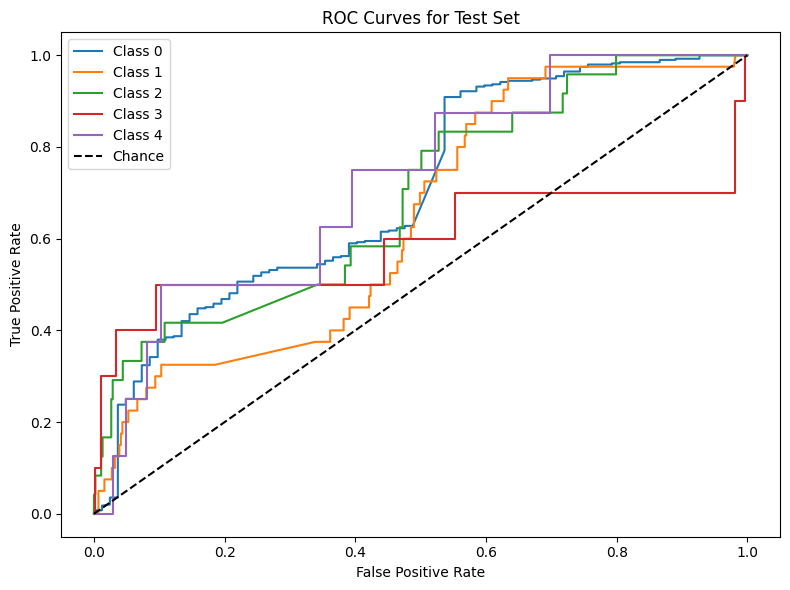

In [7]:
import glob

# for i in range(1, 5):
#     test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
#     # Get model and scaler using glob
#     model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
#     scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
#     # School mapping path
#     school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

#     # Predict on test set
#     predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# temp = "sample"  # hoặc "no_sample" tùy thuộc cách bạn lưu model trước đó

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Đường dẫn đúng cho model Keras (.h5)
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # Trích xuất mapping trường học
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Dự đoán trên tập test
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 13s - 13ms/step - accuracy: 0.5379 - loss: 1.0502 - val_accuracy: 0.5370 - val_loss: 1.0753
Epoch 2/30
987/987 - 5s - 5ms/step - accuracy: 0.6245 - loss: 0.8923 - val_accuracy: 0.5901 - val_loss: 1.0152
Epoch 3/30
987/987 - 4s - 5ms/step - accuracy: 0.6511 - loss: 0.8485 - val_accuracy: 0.5967 - val_loss: 0.9578
Epoch 4/30
987/987 - 5s - 5ms/step - accuracy: 0.6657 - loss: 0.8199 - val_accuracy: 0.5882 - val_loss: 0.9969
Epoch 5/30
987/987 - 5s - 5ms/step - accuracy: 0.6738 - loss: 0.8025 - val_accuracy: 0.5993 - val_loss: 0.9615
Epoch 6/30
987/987 - 5s - 5ms/step - accuracy: 0.6789 - loss: 0.7867 - val_accuracy: 0.6092 - val_loss: 0.9469
Epoch 7/30
987/987 - 5s - 5ms/step - accuracy: 0.6841 - loss: 0.7718 - val_accuracy: 0.6092 - val_loss: 0.9543
Epoch 8/30
987/987 - 5s - 5ms/step - accuracy: 0.6885 - loss: 0.7601 - val_accuracy: 0.6195 - val_loss: 0.9248
Epoch 9/30
987/987 - 4s - 5ms/step - accuracy: 0.6916 - loss: 0.7541 - val_accuracy: 0.5971 - val_loss: 0.9672
Epoch 10/3

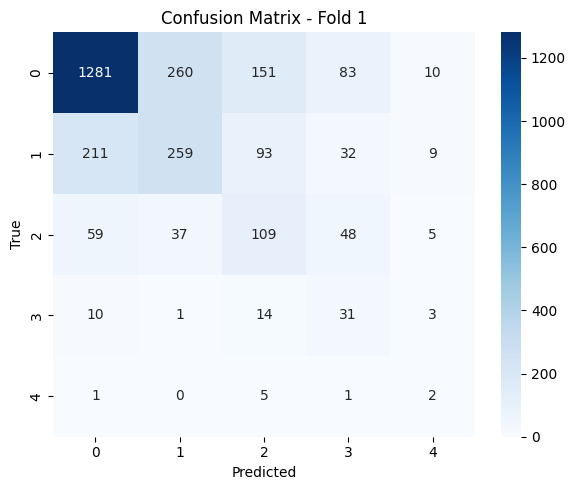

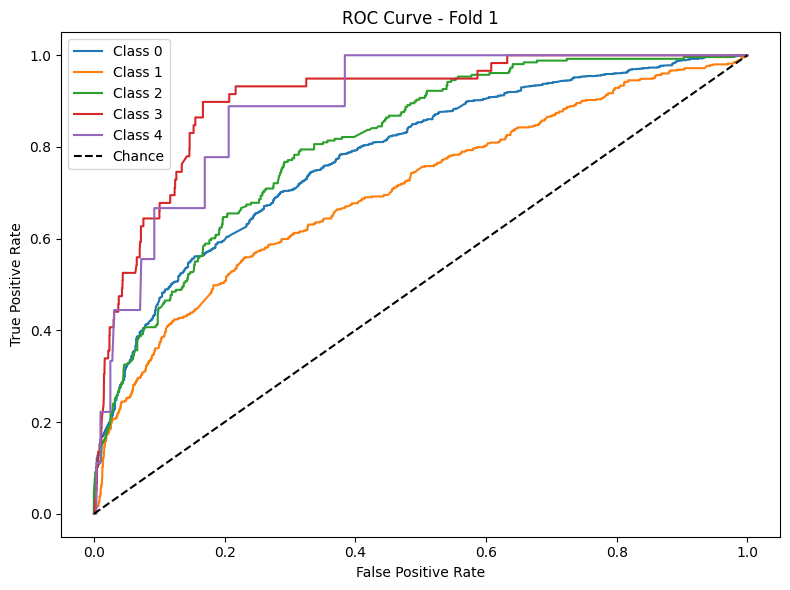

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 17s - 17ms/step - accuracy: 0.5557 - loss: 1.0409 - val_accuracy: 0.5140 - val_loss: 1.1191
Epoch 2/30
987/987 - 5s - 5ms/step - accuracy: 0.6387 - loss: 0.8875 - val_accuracy: 0.5796 - val_loss: 1.0130
Epoch 3/30
987/987 - 5s - 5ms/step - accuracy: 0.6612 - loss: 0.8360 - val_accuracy: 0.5505 - val_loss: 1.0155
Epoch 4/30
987/987 - 5s - 5ms/step - accuracy: 0.6723 - loss: 0.8090 - val_accuracy: 0.5755 - val_loss: 0.9745
Epoch 5/30
987/987 - 6s - 6ms/step - accuracy: 0.6800 - loss: 0.7933 - val_accuracy: 0.5656 - val_loss: 1.0052
Epoch 6/30
987/987 - 5s - 5ms/step - accuracy: 0.6860 - loss: 0.7859 - val_accuracy: 0.5206 - val_loss: 0.9787
Epoch 7/30
987/987 - 5s - 5ms/step - accuracy: 0.6896 - loss: 0.7744 - val_accuracy: 0.5962 - val_loss: 0.9742
Epoch 8/30
987/987 - 5s - 5ms/step - accuracy: 0.6929 - loss: 0.7705 - val_accuracy: 0.5965 - val_loss: 0.9452
Epoch 9/30
987/987 - 5s - 5ms/step - accuracy: 0.6966 - loss: 0.7585 - val_accuracy: 0.5903 - val_loss: 0.9523
Epoch 10/3

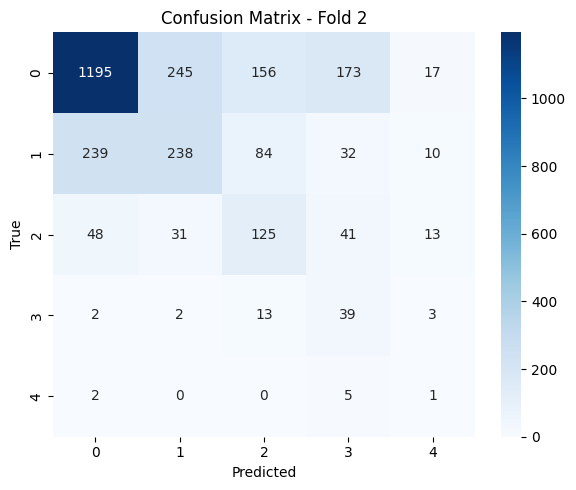

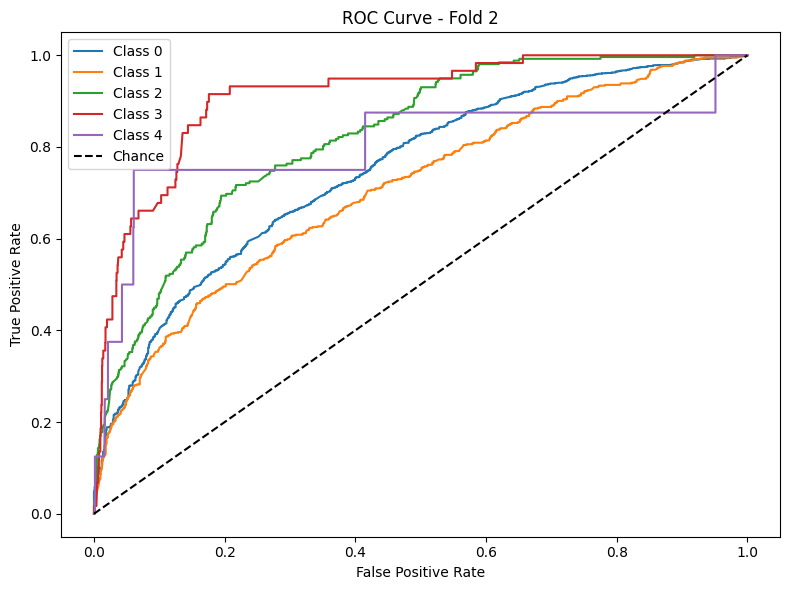

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 15s - 16ms/step - accuracy: 0.5434 - loss: 1.0410 - val_accuracy: 0.5343 - val_loss: 1.0441
Epoch 2/30
987/987 - 5s - 5ms/step - accuracy: 0.6364 - loss: 0.8706 - val_accuracy: 0.5634 - val_loss: 0.9854
Epoch 3/30
987/987 - 5s - 5ms/step - accuracy: 0.6604 - loss: 0.8288 - val_accuracy: 0.5785 - val_loss: 0.9594
Epoch 4/30
987/987 - 5s - 5ms/step - accuracy: 0.6693 - loss: 0.8099 - val_accuracy: 0.5847 - val_loss: 0.9579
Epoch 5/30
987/987 - 5s - 5ms/step - accuracy: 0.6796 - loss: 0.7871 - val_accuracy: 0.5925 - val_loss: 0.9152
Epoch 6/30
987/987 - 5s - 5ms/step - accuracy: 0.6856 - loss: 0.7723 - val_accuracy: 0.5582 - val_loss: 0.9593
Epoch 7/30
987/987 - 5s - 5ms/step - accuracy: 0.6901 - loss: 0.7624 - val_accuracy: 0.5357 - val_loss: 0.9748
Epoch 8/30
987/987 - 5s - 5ms/step - accuracy: 0.6970 - loss: 0.7497 - val_accuracy: 0.6098 - val_loss: 0.9234
Epoch 9/30
987/987 - 5s - 5ms/step - accuracy: 0.6981 - loss: 0.7413 - val_accuracy: 0.5630 - val_loss: 0.9874
Epoch 10/3

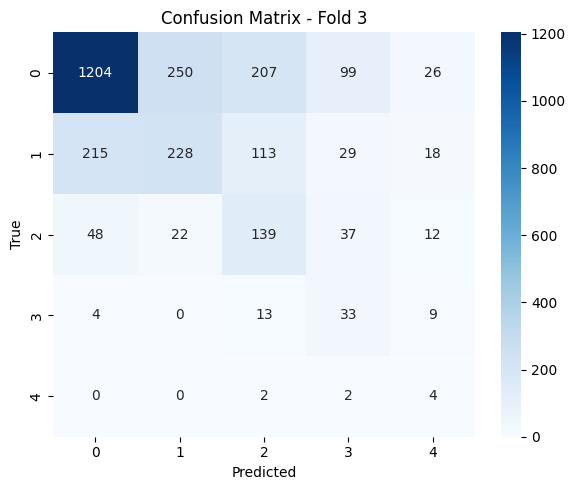

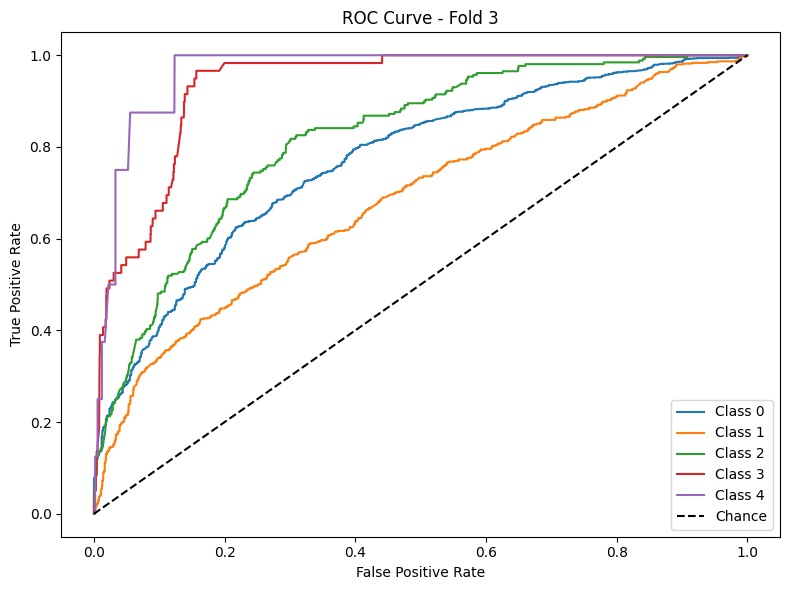

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 13s - 14ms/step - accuracy: 0.5341 - loss: 1.0537 - val_accuracy: 0.5648 - val_loss: 1.0351
Epoch 2/30
987/987 - 5s - 5ms/step - accuracy: 0.6289 - loss: 0.8874 - val_accuracy: 0.5943 - val_loss: 0.9706
Epoch 3/30
987/987 - 4s - 5ms/step - accuracy: 0.6584 - loss: 0.8370 - val_accuracy: 0.5674 - val_loss: 1.0073
Epoch 4/30
987/987 - 5s - 5ms/step - accuracy: 0.6718 - loss: 0.8106 - val_accuracy: 0.5921 - val_loss: 0.9403
Epoch 5/30
987/987 - 4s - 4ms/step - accuracy: 0.6775 - loss: 0.7894 - val_accuracy: 0.5413 - val_loss: 0.9595
Epoch 6/30
987/987 - 4s - 5ms/step - accuracy: 0.6840 - loss: 0.7713 - val_accuracy: 0.5899 - val_loss: 0.9413
Epoch 7/30
987/987 - 5s - 5ms/step - accuracy: 0.6885 - loss: 0.7605 - val_accuracy: 0.5962 - val_loss: 0.9365
Epoch 8/30
987/987 - 4s - 5ms/step - accuracy: 0.6904 - loss: 0.7492 - val_accuracy: 0.5763 - val_loss: 0.9380
Epoch 9/30
987/987 - 4s - 5ms/step - accuracy: 0.6971 - loss: 0.7409 - val_accuracy: 0.5951 - val_loss: 0.9297
Epoch 10/3

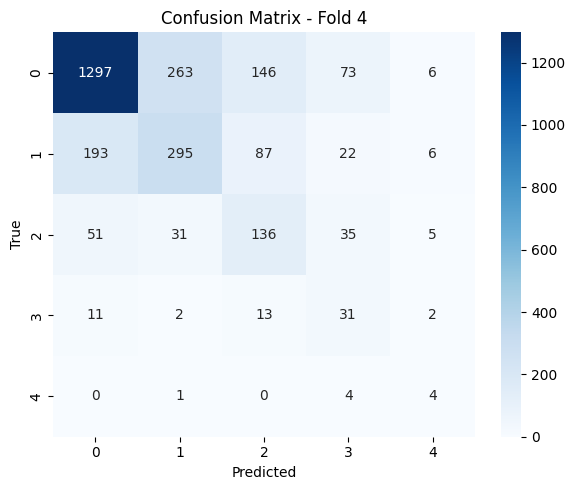

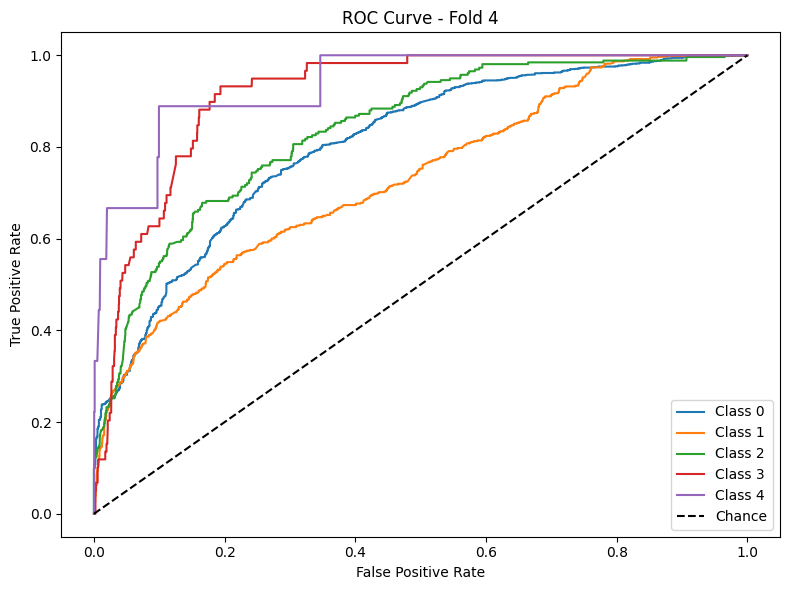

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 15s - 15ms/step - accuracy: 0.5467 - loss: 1.0368 - val_accuracy: 0.5103 - val_loss: 1.0701
Epoch 2/30
987/987 - 4s - 4ms/step - accuracy: 0.6522 - loss: 0.8700 - val_accuracy: 0.5903 - val_loss: 0.9796
Epoch 3/30
987/987 - 4s - 4ms/step - accuracy: 0.6708 - loss: 0.8277 - val_accuracy: 0.5980 - val_loss: 0.9515
Epoch 4/30
987/987 - 5s - 5ms/step - accuracy: 0.6802 - loss: 0.8052 - val_accuracy: 0.5969 - val_loss: 0.9541
Epoch 5/30
987/987 - 4s - 4ms/step - accuracy: 0.6846 - loss: 0.7910 - val_accuracy: 0.5958 - val_loss: 0.9391
Epoch 6/30
987/987 - 4s - 4ms/step - accuracy: 0.6914 - loss: 0.7776 - val_accuracy: 0.6135 - val_loss: 0.9225
Epoch 7/30
987/987 - 4s - 4ms/step - accuracy: 0.6973 - loss: 0.7645 - val_accuracy: 0.6065 - val_loss: 0.9325
Epoch 8/30
987/987 - 4s - 5ms/step - accuracy: 0.6993 - loss: 0.7569 - val_accuracy: 0.5531 - val_loss: 0.9555
Epoch 9/30
987/987 - 4s - 4ms/step - accuracy: 0.7037 - loss: 0.7470 - val_accuracy: 0.6124 - val_loss: 0.9075
Epoch 10/3

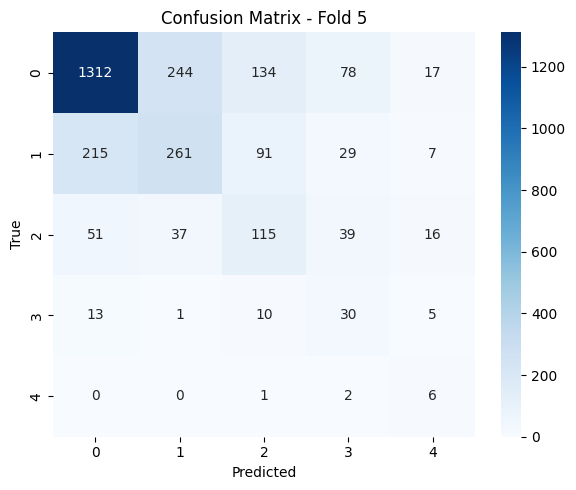

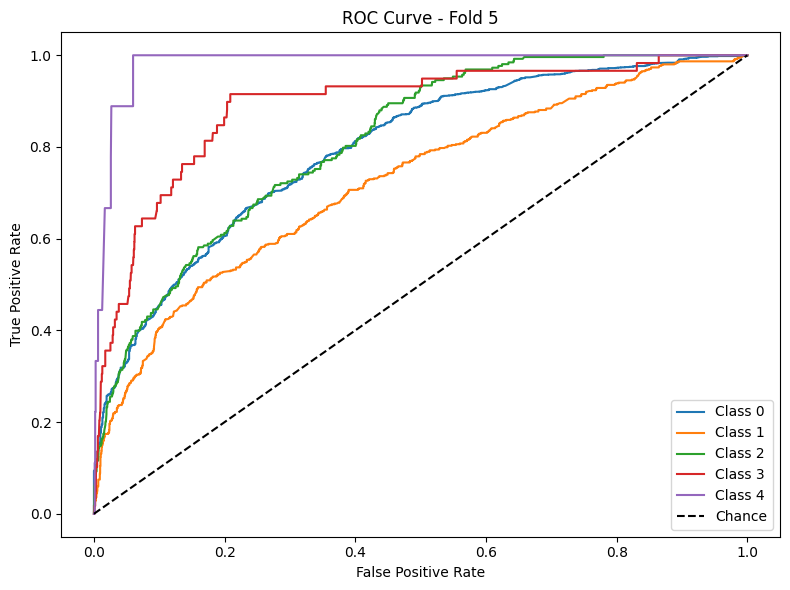


Average Accuracy: 0.6171
Average F1 Macro: 0.3958
Average AUC: 0.8269

=== Training Phase 2 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 14s - 17ms/step - accuracy: 0.5445 - loss: 1.0447 - val_accuracy: 0.5199 - val_loss: 1.1107
Epoch 2/30
824/824 - 4s - 5ms/step - accuracy: 0.6311 - loss: 0.8754 - val_accuracy: 0.5558 - val_loss: 1.0566
Epoch 3/30
824/824 - 4s - 5ms/step - accuracy: 0.6600 - loss: 0.8246 - val_accuracy: 0.5996 - val_loss: 0.9641
Epoch 4/30
824/824 - 4s - 5ms/step - accuracy: 0.6737 - loss: 0.7984 - val_accuracy: 0.5907 - val_loss: 0.9930
Epoch 5/30
824/824 - 4s - 5ms/step - accuracy: 0.6819 - loss: 0.7795 - val_accuracy: 0.5748 - val_loss: 1.0018
Epoch 6/30
824/824 - 4s - 5ms/step - accuracy: 0.6858 - loss: 0.7640 - val_accuracy: 0.5659 - val_loss: 0.9815
Epoch 7/30
824/824 - 4s - 5ms/step - accuracy: 0.6938 - loss: 0.7525 - val_accuracy: 0.5186 - val_loss: 1.0403
Epoch 8/30
824/824 - 4s - 5ms/step - accuracy: 0.6911 - loss: 0.7468 - val_accuracy: 0.5412 - val_loss: 0.9963
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Fold 1 Classification Report:
               precision    recall  f1-score   sup

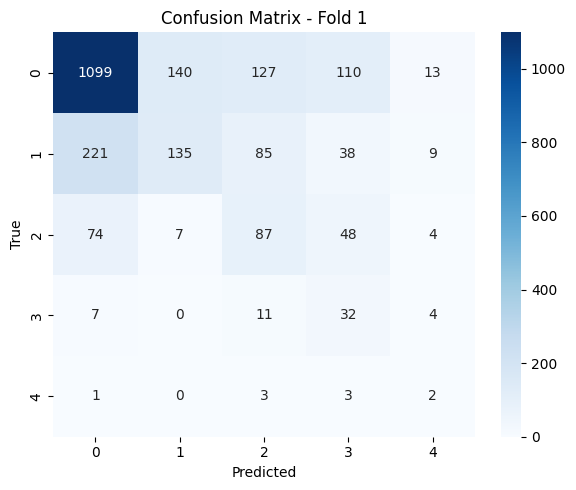

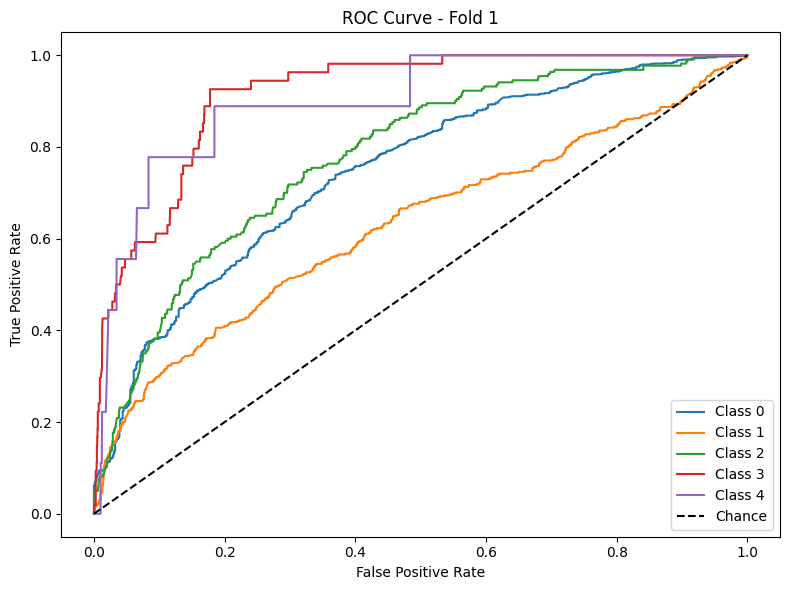

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 16s - 20ms/step - accuracy: 0.5440 - loss: 1.0302 - val_accuracy: 0.4270 - val_loss: 1.1146
Epoch 2/30
824/824 - 4s - 5ms/step - accuracy: 0.6279 - loss: 0.8718 - val_accuracy: 0.4951 - val_loss: 1.0807
Epoch 3/30
824/824 - 5s - 5ms/step - accuracy: 0.6521 - loss: 0.8265 - val_accuracy: 0.5991 - val_loss: 1.0245
Epoch 4/30
824/824 - 4s - 5ms/step - accuracy: 0.6688 - loss: 0.8044 - val_accuracy: 0.6111 - val_loss: 0.9980
Epoch 5/30
824/824 - 4s - 5ms/step - accuracy: 0.6807 - loss: 0.7787 - val_accuracy: 0.6040 - val_loss: 0.9845
Epoch 6/30
824/824 - 4s - 5ms/step - accuracy: 0.6847 - loss: 0.7628 - val_accuracy: 0.6009 - val_loss: 0.9730
Epoch 7/30
824/824 - 4s - 5ms/step - accuracy: 0.6946 - loss: 0.7461 - val_accuracy: 0.6004 - val_loss: 0.9562
Epoch 8/30
824/824 - 4s - 5ms/step - accuracy: 0.6959 - loss: 0.7406 - val_accuracy: 0.5872 - val_loss: 0.9823
Epoch 9/30
824/824 - 4s - 5ms/step - accuracy: 0.7039 - loss: 0.7291 - val_accuracy: 0.5819 - val_loss: 0.9753
Epoch 10/3

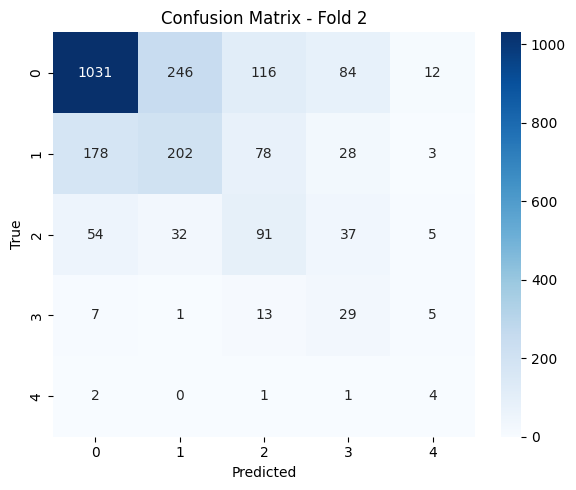

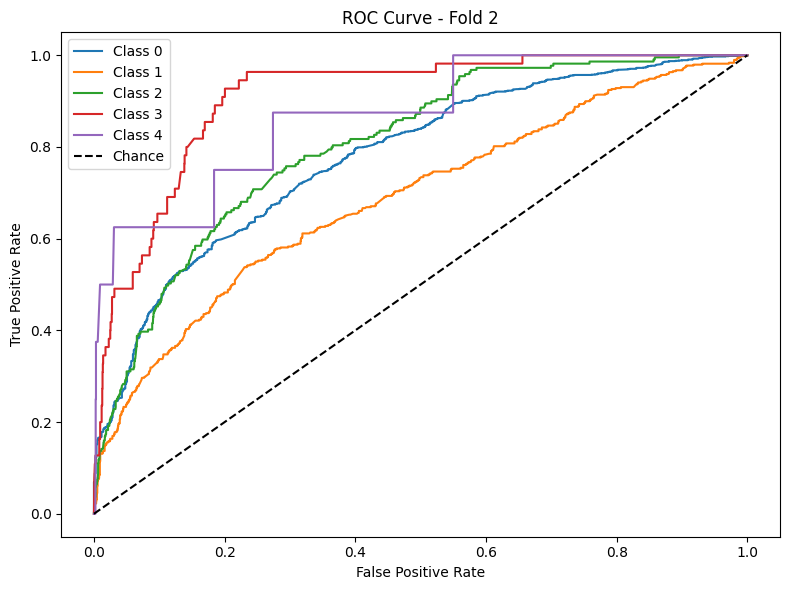

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 14s - 17ms/step - accuracy: 0.5523 - loss: 1.0311 - val_accuracy: 0.4170 - val_loss: 1.1761
Epoch 2/30
824/824 - 4s - 5ms/step - accuracy: 0.6425 - loss: 0.8702 - val_accuracy: 0.5772 - val_loss: 1.0534
Epoch 3/30
824/824 - 5s - 5ms/step - accuracy: 0.6596 - loss: 0.8278 - val_accuracy: 0.5826 - val_loss: 1.0154
Epoch 4/30
824/824 - 5s - 5ms/step - accuracy: 0.6743 - loss: 0.7926 - val_accuracy: 0.5361 - val_loss: 1.0368
Epoch 5/30
824/824 - 5s - 6ms/step - accuracy: 0.6849 - loss: 0.7701 - val_accuracy: 0.5945 - val_loss: 0.9614
Epoch 6/30
824/824 - 5s - 6ms/step - accuracy: 0.6915 - loss: 0.7570 - val_accuracy: 0.5746 - val_loss: 1.0339
Epoch 7/30
824/824 - 5s - 6ms/step - accuracy: 0.6980 - loss: 0.7454 - val_accuracy: 0.5755 - val_loss: 0.9641
Epoch 8/30
824/824 - 5s - 6ms/step - accuracy: 0.6984 - loss: 0.7397 - val_accuracy: 0.5525 - val_loss: 1.0213
Epoch 9/30
824/824 - 5s - 6ms/step - accuracy: 0.7047 - loss: 0.7256 - val_accuracy: 0.5724 - val_loss: 0.9615
Epoch 10/3

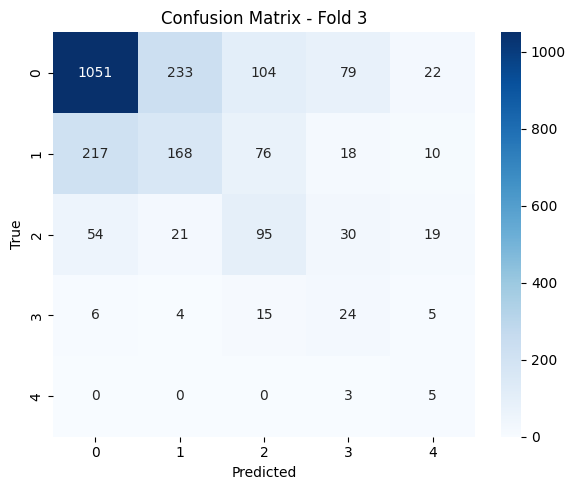

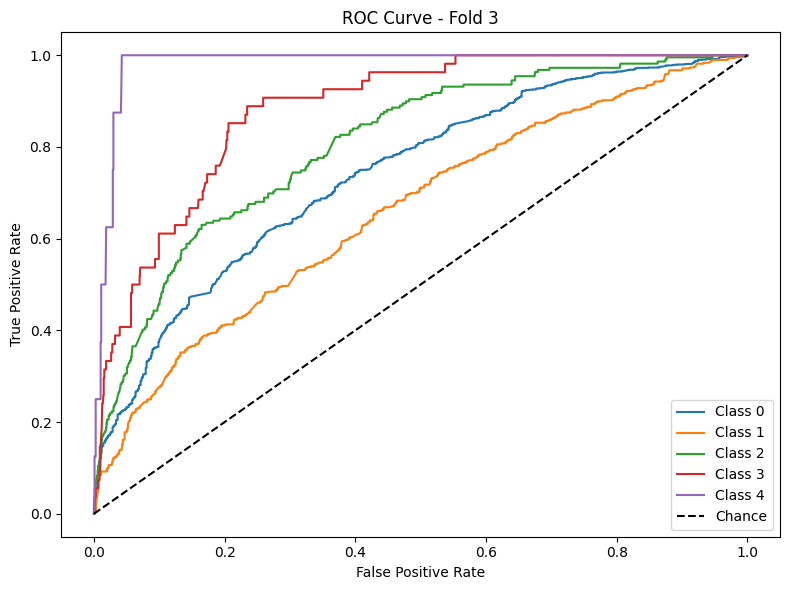

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 15s - 18ms/step - accuracy: 0.5496 - loss: 1.0436 - val_accuracy: 0.4706 - val_loss: 1.0625
Epoch 2/30
824/824 - 4s - 5ms/step - accuracy: 0.6418 - loss: 0.8770 - val_accuracy: 0.6029 - val_loss: 0.9647
Epoch 3/30
824/824 - 5s - 5ms/step - accuracy: 0.6670 - loss: 0.8289 - val_accuracy: 0.5263 - val_loss: 1.0177
Epoch 4/30
824/824 - 4s - 5ms/step - accuracy: 0.6744 - loss: 0.8063 - val_accuracy: 0.5950 - val_loss: 0.9357
Epoch 5/30
824/824 - 4s - 5ms/step - accuracy: 0.6858 - loss: 0.7873 - val_accuracy: 0.5994 - val_loss: 0.9376
Epoch 6/30
824/824 - 5s - 6ms/step - accuracy: 0.6890 - loss: 0.7778 - val_accuracy: 0.5675 - val_loss: 0.9672
Epoch 7/30
824/824 - 4s - 5ms/step - accuracy: 0.6966 - loss: 0.7627 - val_accuracy: 0.5671 - val_loss: 0.9599
Epoch 8/30
824/824 - 5s - 6ms/step - accuracy: 0.7002 - loss: 0.7562 - val_accuracy: 0.5919 - val_loss: 0.9365
Epoch 9/30
824/824 - 4s - 5ms/step - accuracy: 0.7023 - loss: 0.7460 - val_accuracy: 0.5852 - val_loss: 0.9606
71/71 ━━━━

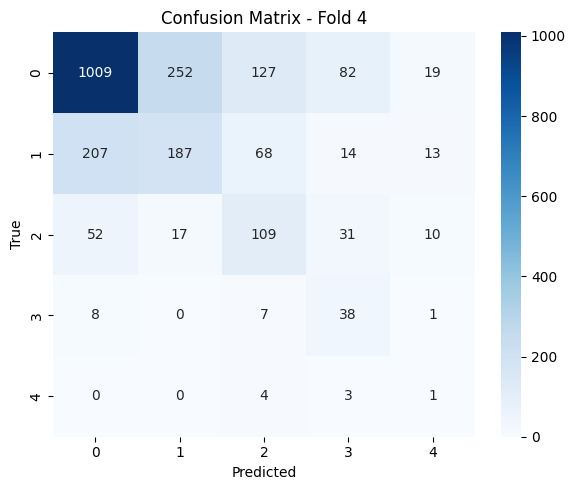

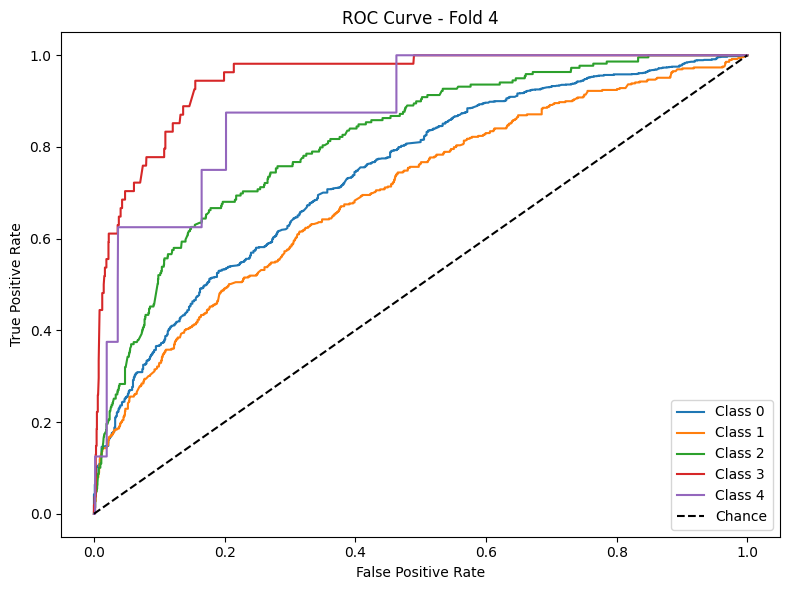

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 17s - 21ms/step - accuracy: 0.5420 - loss: 1.0451 - val_accuracy: 0.4945 - val_loss: 1.1235
Epoch 2/30
824/824 - 5s - 6ms/step - accuracy: 0.6319 - loss: 0.8804 - val_accuracy: 0.5170 - val_loss: 1.1005
Epoch 3/30
824/824 - 5s - 6ms/step - accuracy: 0.6581 - loss: 0.8343 - val_accuracy: 0.5706 - val_loss: 1.0290
Epoch 4/30
824/824 - 4s - 5ms/step - accuracy: 0.6718 - loss: 0.8073 - val_accuracy: 0.5591 - val_loss: 1.0263
Epoch 5/30
824/824 - 4s - 5ms/step - accuracy: 0.6799 - loss: 0.7889 - val_accuracy: 0.5587 - val_loss: 0.9843
Epoch 6/30
824/824 - 5s - 6ms/step - accuracy: 0.6895 - loss: 0.7723 - val_accuracy: 0.5618 - val_loss: 1.0169
Epoch 7/30
824/824 - 5s - 6ms/step - accuracy: 0.6976 - loss: 0.7544 - val_accuracy: 0.5830 - val_loss: 0.9541
Epoch 8/30
824/824 - 4s - 5ms/step - accuracy: 0.6991 - loss: 0.7432 - val_accuracy: 0.5467 - val_loss: 1.0233
Epoch 9/30
824/824 - 4s - 5ms/step - accuracy: 0.7073 - loss: 0.7309 - val_accuracy: 0.5755 - val_loss: 0.9842
Epoch 10/3

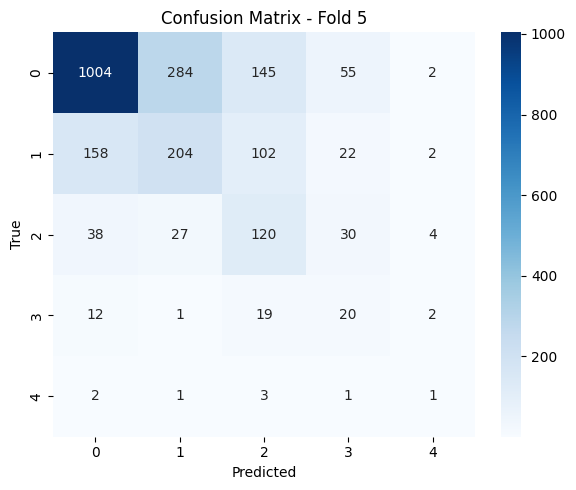

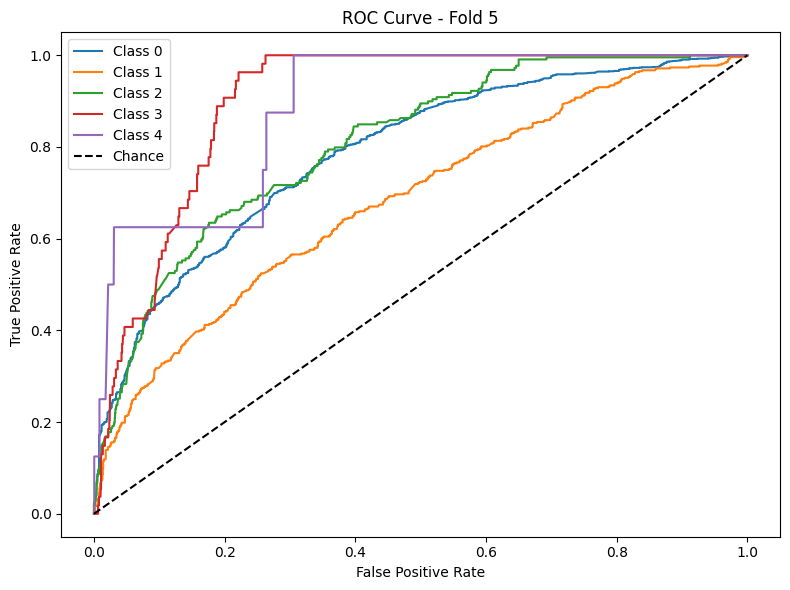


Average Accuracy: 0.5973
Average F1 Macro: 0.3753
Average AUC: 0.8098

=== Training Phase 3 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 14s - 18ms/step - accuracy: 0.5290 - loss: 1.0523 - val_accuracy: 0.3293 - val_loss: 1.1417
Epoch 2/30
752/752 - 4s - 5ms/step - accuracy: 0.6356 - loss: 0.8614 - val_accuracy: 0.5554 - val_loss: 1.0368
Epoch 3/30
752/752 - 4s - 5ms/step - accuracy: 0.6730 - loss: 0.8111 - val_accuracy: 0.6099 - val_loss: 0.9807
Epoch 4/30
752/752 - 4s - 5ms/step - accuracy: 0.6880 - loss: 0.7792 - val_accuracy: 0.5868 - val_loss: 1.0058
Epoch 5/30
752/752 - 4s - 6ms/step - accuracy: 0.7015 - loss: 0.7619 - val_accuracy: 0.5718 - val_loss: 0.9939
Epoch 6/30
752/752 - 4s - 5ms/step - accuracy: 0.7069 - loss: 0.7436 - val_accuracy: 0.6311 - val_loss: 0.9223
Epoch 7/30
752/752 - 4s - 5ms/step - accuracy: 0.7103 - loss: 0.7331 - val_accuracy: 0.5945 - val_loss: 0.9597
Epoch 8/30
752/752 - 4s - 5ms/step - accuracy: 0.7183 - loss: 0.7210 - val_accuracy: 0.5738 - val_loss: 0.9809
Epoch 9/30
752/752 - 4s - 5ms/step - accuracy: 0.7236 - loss: 0.7142 - val_accuracy: 0.5771 - val_loss: 0.9884
Epoch 10/3

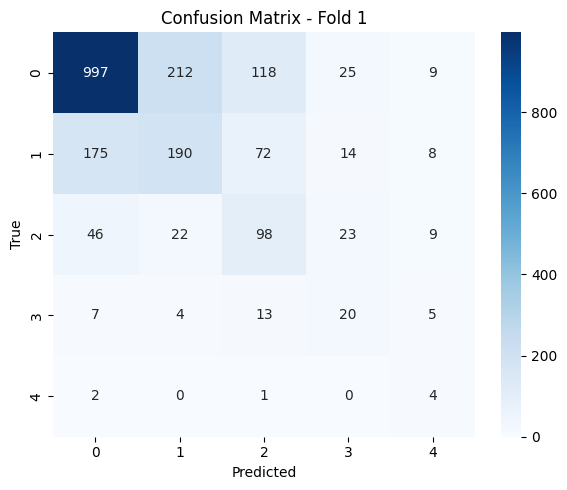

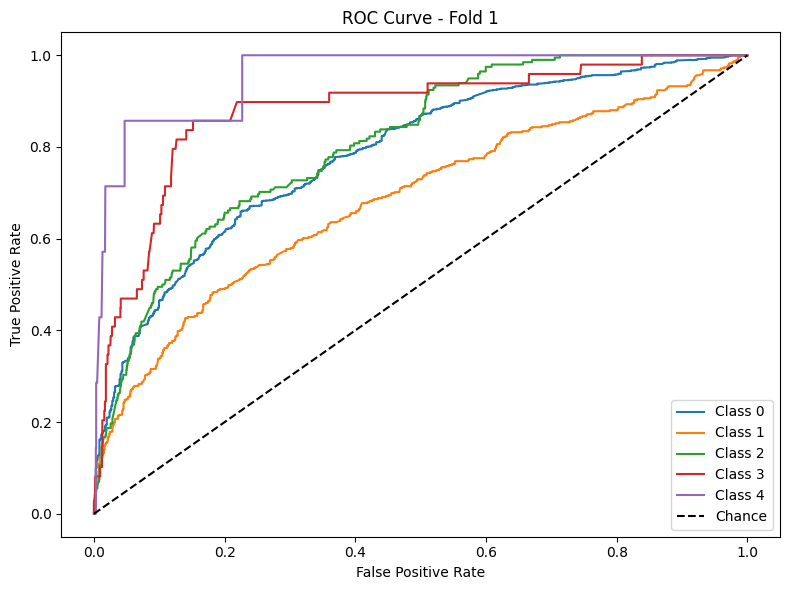

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 14s - 18ms/step - accuracy: 0.5397 - loss: 1.0345 - val_accuracy: 0.2840 - val_loss: 1.1213
Epoch 2/30
752/752 - 4s - 5ms/step - accuracy: 0.6268 - loss: 0.8724 - val_accuracy: 0.5169 - val_loss: 1.0659
Epoch 3/30
752/752 - 4s - 5ms/step - accuracy: 0.6665 - loss: 0.8265 - val_accuracy: 0.5612 - val_loss: 1.0380
Epoch 4/30
752/752 - 4s - 5ms/step - accuracy: 0.6800 - loss: 0.7942 - val_accuracy: 0.6176 - val_loss: 0.9776
Epoch 5/30
752/752 - 4s - 5ms/step - accuracy: 0.6910 - loss: 0.7741 - val_accuracy: 0.5824 - val_loss: 1.0002
Epoch 6/30
752/752 - 4s - 5ms/step - accuracy: 0.6991 - loss: 0.7540 - val_accuracy: 0.5998 - val_loss: 0.9569
Epoch 7/30
752/752 - 4s - 6ms/step - accuracy: 0.7056 - loss: 0.7445 - val_accuracy: 0.5689 - val_loss: 0.9902
Epoch 8/30
752/752 - 4s - 5ms/step - accuracy: 0.7147 - loss: 0.7305 - val_accuracy: 0.5554 - val_loss: 0.9836
Epoch 9/30
752/752 - 4s - 5ms/step - accuracy: 0.7177 - loss: 0.7203 - val_accuracy: 0.5897 - val_loss: 0.9629
Epoch 10/3

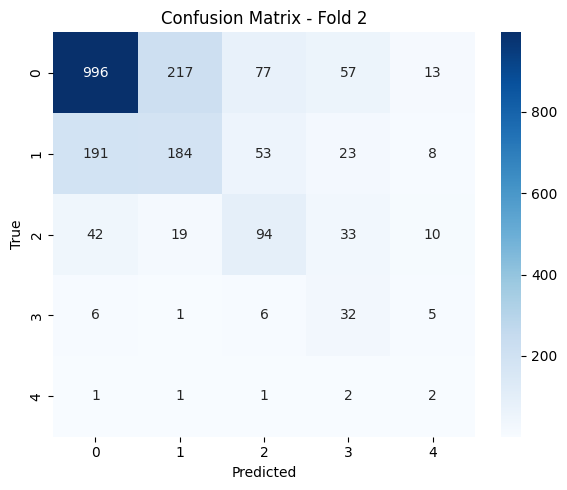

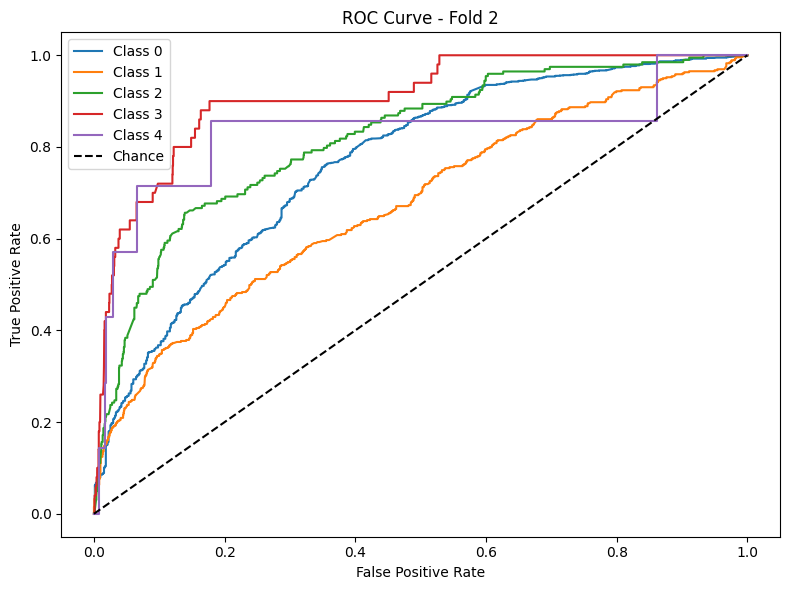

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 17s - 22ms/step - accuracy: 0.5355 - loss: 1.0611 - val_accuracy: 0.4672 - val_loss: 1.1645
Epoch 2/30
752/752 - 4s - 5ms/step - accuracy: 0.6461 - loss: 0.8637 - val_accuracy: 0.5593 - val_loss: 1.0991
Epoch 3/30
752/752 - 4s - 5ms/step - accuracy: 0.6733 - loss: 0.8152 - val_accuracy: 0.5352 - val_loss: 1.0684
Epoch 4/30
752/752 - 4s - 6ms/step - accuracy: 0.6850 - loss: 0.7830 - val_accuracy: 0.5661 - val_loss: 1.0098
Epoch 5/30
752/752 - 4s - 5ms/step - accuracy: 0.6881 - loss: 0.7686 - val_accuracy: 0.5444 - val_loss: 0.9890
Epoch 6/30
752/752 - 4s - 5ms/step - accuracy: 0.7023 - loss: 0.7427 - val_accuracy: 0.5260 - val_loss: 1.0183
Epoch 7/30
752/752 - 4s - 5ms/step - accuracy: 0.7083 - loss: 0.7377 - val_accuracy: 0.5366 - val_loss: 0.9814
Epoch 8/30
752/752 - 4s - 5ms/step - accuracy: 0.7126 - loss: 0.7253 - val_accuracy: 0.5289 - val_loss: 1.0372
Epoch 9/30
752/752 - 4s - 5ms/step - accuracy: 0.7170 - loss: 0.7160 - val_accuracy: 0.5497 - val_loss: 0.9825
Epoch 10/3

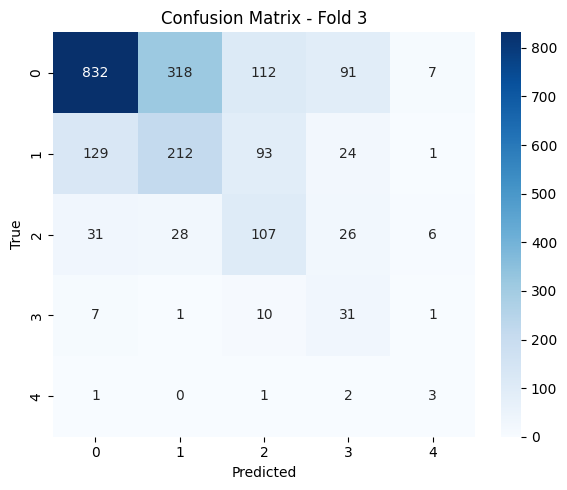

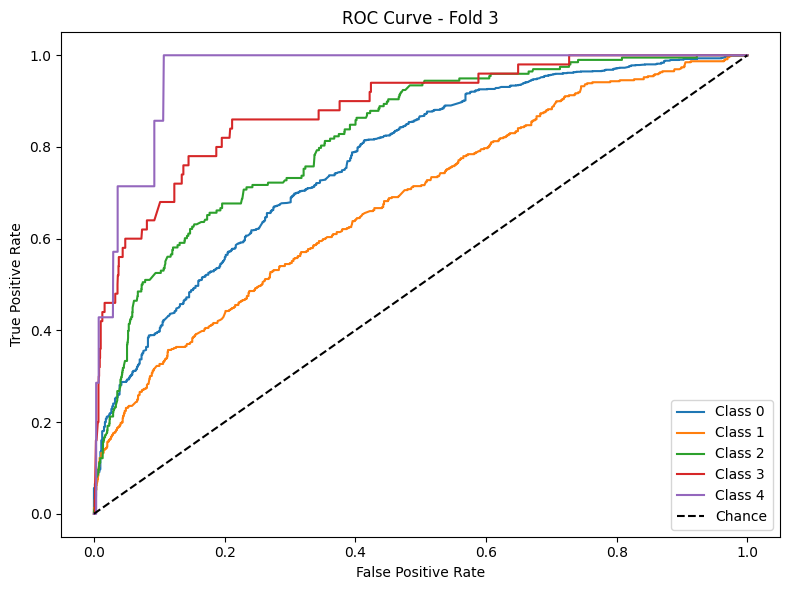

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 14s - 18ms/step - accuracy: 0.5514 - loss: 1.0492 - val_accuracy: 0.3780 - val_loss: 1.1269
Epoch 2/30
752/752 - 4s - 5ms/step - accuracy: 0.6508 - loss: 0.8615 - val_accuracy: 0.5868 - val_loss: 1.0181
Epoch 3/30
752/752 - 4s - 5ms/step - accuracy: 0.6801 - loss: 0.8085 - val_accuracy: 0.5979 - val_loss: 1.0196
Epoch 4/30
752/752 - 4s - 5ms/step - accuracy: 0.6915 - loss: 0.7785 - val_accuracy: 0.5718 - val_loss: 1.0039
Epoch 5/30
752/752 - 4s - 5ms/step - accuracy: 0.7024 - loss: 0.7583 - val_accuracy: 0.5694 - val_loss: 0.9835
Epoch 6/30
752/752 - 4s - 5ms/step - accuracy: 0.7047 - loss: 0.7431 - val_accuracy: 0.6070 - val_loss: 0.9552
Epoch 7/30
752/752 - 4s - 5ms/step - accuracy: 0.7098 - loss: 0.7326 - val_accuracy: 0.6008 - val_loss: 0.9232
Epoch 8/30
752/752 - 4s - 5ms/step - accuracy: 0.7153 - loss: 0.7165 - val_accuracy: 0.6215 - val_loss: 0.9225
Epoch 9/30
752/752 - 4s - 5ms/step - accuracy: 0.7179 - loss: 0.7110 - val_accuracy: 0.5940 - val_loss: 0.9412
Epoch 10/3

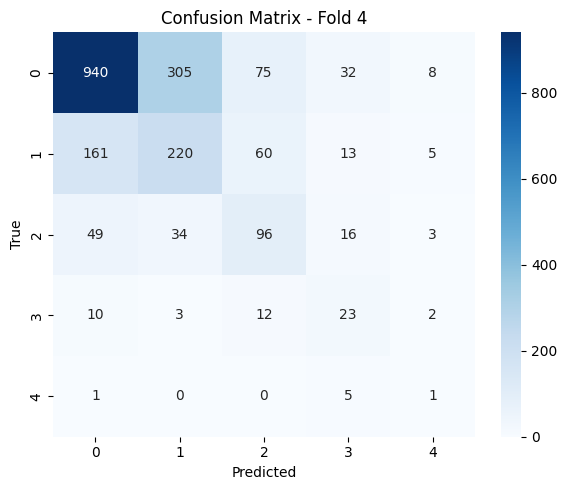

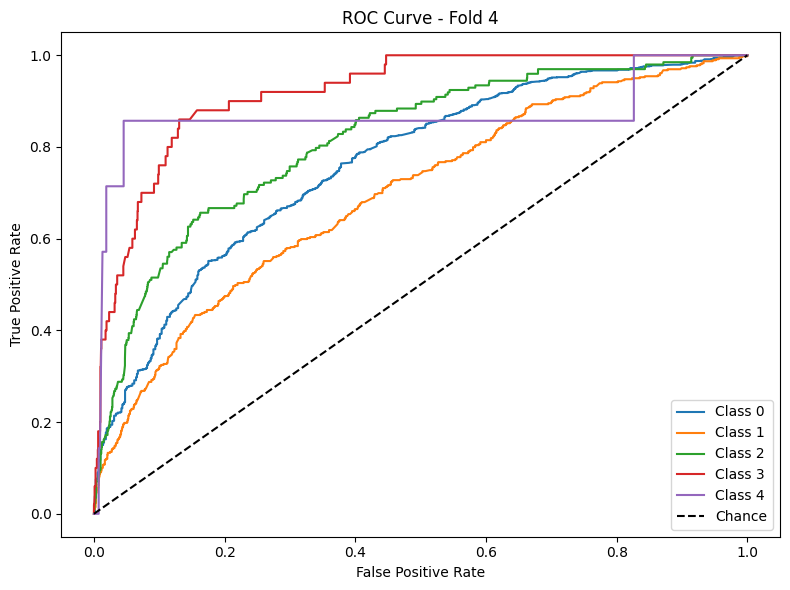

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 14s - 18ms/step - accuracy: 0.5621 - loss: 1.0038 - val_accuracy: 0.5186 - val_loss: 1.1281
Epoch 2/30
752/752 - 4s - 5ms/step - accuracy: 0.6622 - loss: 0.8308 - val_accuracy: 0.5900 - val_loss: 1.0485
Epoch 3/30
752/752 - 4s - 5ms/step - accuracy: 0.6857 - loss: 0.7888 - val_accuracy: 0.6049 - val_loss: 1.0269
Epoch 4/30
752/752 - 4s - 5ms/step - accuracy: 0.6968 - loss: 0.7622 - val_accuracy: 0.5919 - val_loss: 1.0483
Epoch 5/30
752/752 - 4s - 5ms/step - accuracy: 0.7059 - loss: 0.7443 - val_accuracy: 0.5996 - val_loss: 0.9878
Epoch 6/30
752/752 - 4s - 5ms/step - accuracy: 0.7125 - loss: 0.7262 - val_accuracy: 0.5760 - val_loss: 1.0460
Epoch 7/30
752/752 - 4s - 5ms/step - accuracy: 0.7191 - loss: 0.7154 - val_accuracy: 0.5972 - val_loss: 1.0125
Epoch 8/30
752/752 - 4s - 5ms/step - accuracy: 0.7231 - loss: 0.7049 - val_accuracy: 0.5707 - val_loss: 1.0126
Epoch 9/30
752/752 - 4s - 5ms/step - accuracy: 0.7261 - loss: 0.6961 - val_accuracy: 0.5895 - val_loss: 1.0347
Epoch 10/3

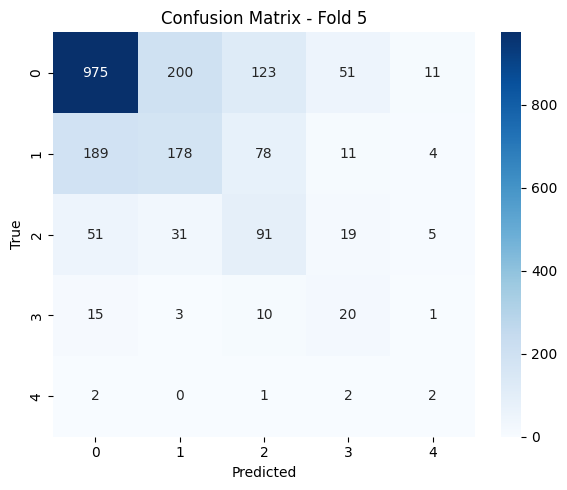

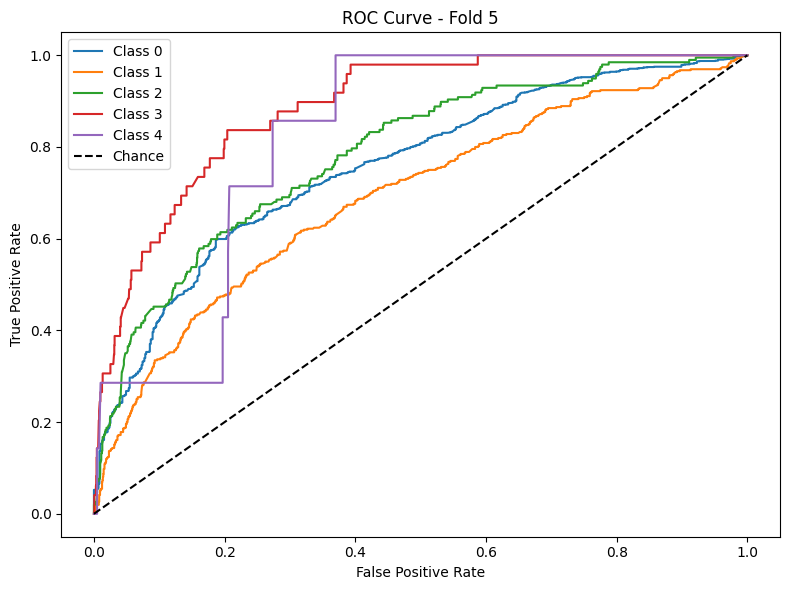


Average Accuracy: 0.6122
Average F1 Macro: 0.4046
Average AUC: 0.8095

=== Training Phase 4 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 16s - 28ms/step - accuracy: 0.5289 - loss: 1.0574 - val_accuracy: 0.3639 - val_loss: 1.1935
Epoch 2/30
553/553 - 3s - 5ms/step - accuracy: 0.6492 - loss: 0.8372 - val_accuracy: 0.4587 - val_loss: 1.1360
Epoch 3/30
553/553 - 3s - 5ms/step - accuracy: 0.6816 - loss: 0.7851 - val_accuracy: 0.5556 - val_loss: 1.0631
Epoch 4/30
553/553 - 3s - 5ms/step - accuracy: 0.7060 - loss: 0.7470 - val_accuracy: 0.5757 - val_loss: 1.0371
Epoch 5/30
553/553 - 3s - 6ms/step - accuracy: 0.7157 - loss: 0.7201 - val_accuracy: 0.5673 - val_loss: 1.0474
Epoch 6/30
553/553 - 3s - 5ms/step - accuracy: 0.7237 - loss: 0.7084 - val_accuracy: 0.5952 - val_loss: 0.9885
Epoch 7/30
553/553 - 3s - 5ms/step - accuracy: 0.7256 - loss: 0.6989 - val_accuracy: 0.5536 - val_loss: 1.0369
Epoch 8/30
553/553 - 3s - 5ms/step - accuracy: 0.7315 - loss: 0.6878 - val_accuracy: 0.5939 - val_loss: 0.9841
Epoch 9/30
553/553 - 3s - 5ms/step - accuracy: 0.7363 - loss: 0.6757 - val_accuracy: 0.5712 - val_loss: 1.0346
Epoch 10/3

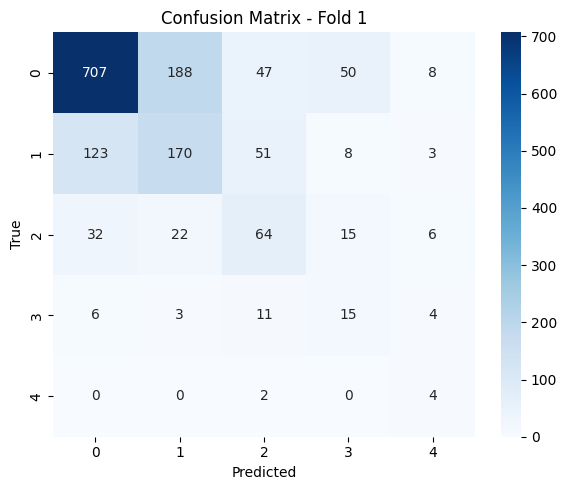

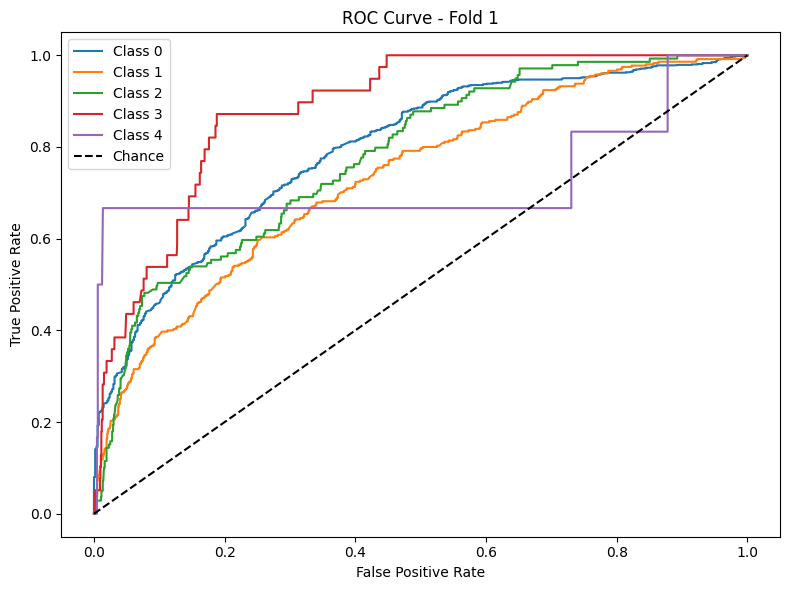

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 13s - 23ms/step - accuracy: 0.5444 - loss: 1.0260 - val_accuracy: 0.5010 - val_loss: 1.1477
Epoch 2/30
553/553 - 3s - 5ms/step - accuracy: 0.6795 - loss: 0.8026 - val_accuracy: 0.5705 - val_loss: 1.1007
Epoch 3/30
553/553 - 3s - 5ms/step - accuracy: 0.7090 - loss: 0.7551 - val_accuracy: 0.5757 - val_loss: 1.0772
Epoch 4/30
553/553 - 3s - 5ms/step - accuracy: 0.7263 - loss: 0.7245 - val_accuracy: 0.5614 - val_loss: 1.0574
Epoch 5/30
553/553 - 3s - 5ms/step - accuracy: 0.7390 - loss: 0.6976 - val_accuracy: 0.5887 - val_loss: 0.9758
Epoch 6/30
553/553 - 3s - 5ms/step - accuracy: 0.7434 - loss: 0.6790 - val_accuracy: 0.5906 - val_loss: 0.9980
Epoch 7/30
553/553 - 3s - 5ms/step - accuracy: 0.7541 - loss: 0.6631 - val_accuracy: 0.5984 - val_loss: 0.9821
Epoch 8/30
553/553 - 3s - 5ms/step - accuracy: 0.7596 - loss: 0.6476 - val_accuracy: 0.5952 - val_loss: 1.0077
Epoch 9/30
553/553 - 3s - 5ms/step - accuracy: 0.7636 - loss: 0.6396 - val_accuracy: 0.5705 - val_loss: 1.0047
Epoch 10/3

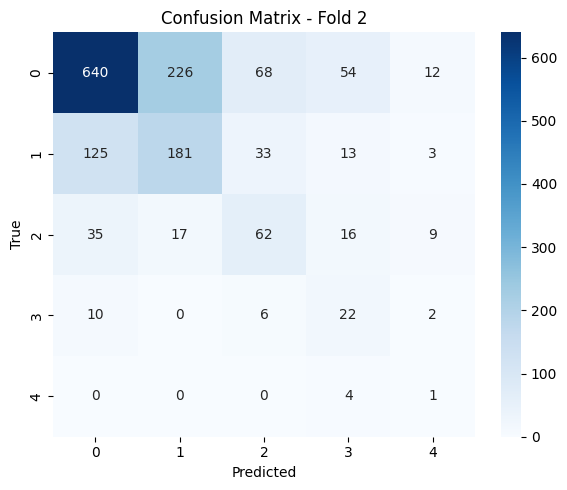

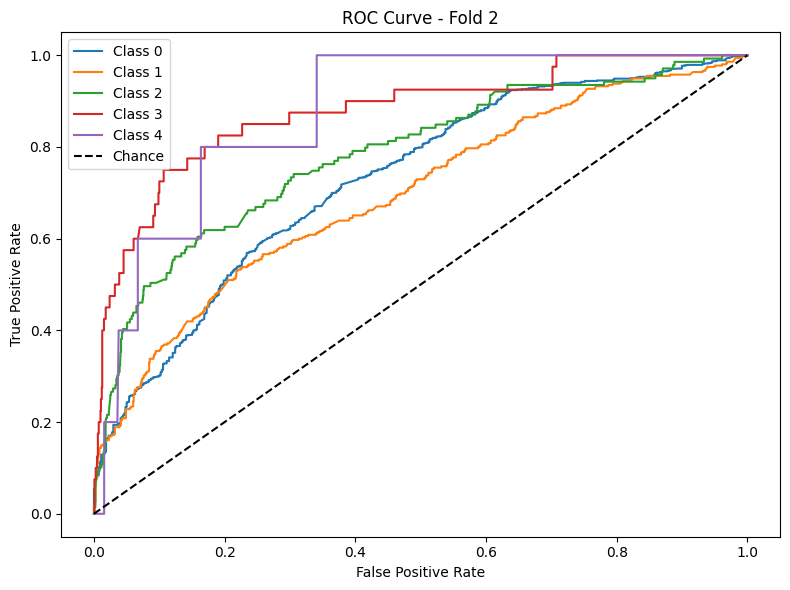

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 13s - 23ms/step - accuracy: 0.5582 - loss: 1.0132 - val_accuracy: 0.5588 - val_loss: 1.0668
Epoch 2/30
553/553 - 3s - 5ms/step - accuracy: 0.6789 - loss: 0.7833 - val_accuracy: 0.5478 - val_loss: 1.0608
Epoch 3/30
553/553 - 3s - 5ms/step - accuracy: 0.7099 - loss: 0.7302 - val_accuracy: 0.6101 - val_loss: 0.9597
Epoch 4/30
553/553 - 3s - 5ms/step - accuracy: 0.7228 - loss: 0.7046 - val_accuracy: 0.5763 - val_loss: 0.9790
Epoch 5/30
553/553 - 3s - 5ms/step - accuracy: 0.7344 - loss: 0.6879 - val_accuracy: 0.5965 - val_loss: 0.9289
Epoch 6/30
553/553 - 3s - 5ms/step - accuracy: 0.7386 - loss: 0.6693 - val_accuracy: 0.5588 - val_loss: 0.9951
Epoch 7/30
553/553 - 3s - 6ms/step - accuracy: 0.7424 - loss: 0.6617 - val_accuracy: 0.6062 - val_loss: 0.9480
Epoch 8/30
553/553 - 3s - 5ms/step - accuracy: 0.7487 - loss: 0.6479 - val_accuracy: 0.6030 - val_loss: 0.9321
Epoch 9/30
553/553 - 3s - 5ms/step - accuracy: 0.7505 - loss: 0.6425 - val_accuracy: 0.6303 - val_loss: 0.8944
Epoch 10/3

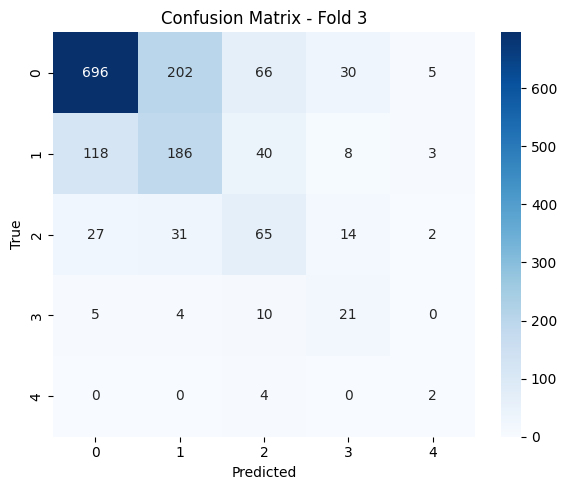

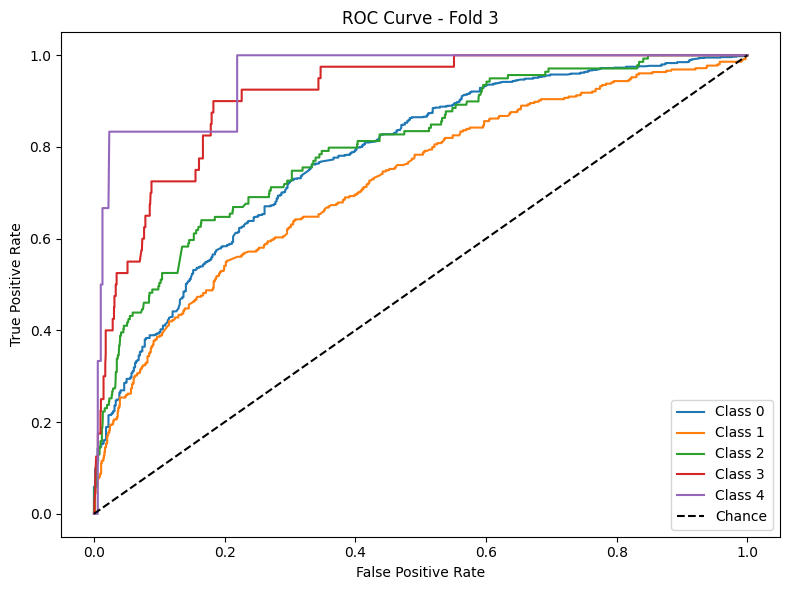

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 16s - 28ms/step - accuracy: 0.5399 - loss: 1.0449 - val_accuracy: 0.4389 - val_loss: 1.1321
Epoch 2/30
553/553 - 3s - 5ms/step - accuracy: 0.6636 - loss: 0.8183 - val_accuracy: 0.5475 - val_loss: 1.0743
Epoch 3/30
553/553 - 3s - 5ms/step - accuracy: 0.6917 - loss: 0.7731 - val_accuracy: 0.5865 - val_loss: 1.0703
Epoch 4/30
553/553 - 3s - 5ms/step - accuracy: 0.7103 - loss: 0.7434 - val_accuracy: 0.6398 - val_loss: 0.9974
Epoch 5/30
553/553 - 3s - 5ms/step - accuracy: 0.7253 - loss: 0.7180 - val_accuracy: 0.5949 - val_loss: 1.0237
Epoch 6/30
553/553 - 3s - 5ms/step - accuracy: 0.7325 - loss: 0.6963 - val_accuracy: 0.5553 - val_loss: 1.0291
Epoch 7/30
553/553 - 3s - 5ms/step - accuracy: 0.7407 - loss: 0.6794 - val_accuracy: 0.6274 - val_loss: 0.9853
Epoch 8/30
553/553 - 3s - 5ms/step - accuracy: 0.7476 - loss: 0.6666 - val_accuracy: 0.6365 - val_loss: 0.9353
Epoch 9/30
553/553 - 3s - 5ms/step - accuracy: 0.7507 - loss: 0.6574 - val_accuracy: 0.6203 - val_loss: 0.9582
Epoch 10/3

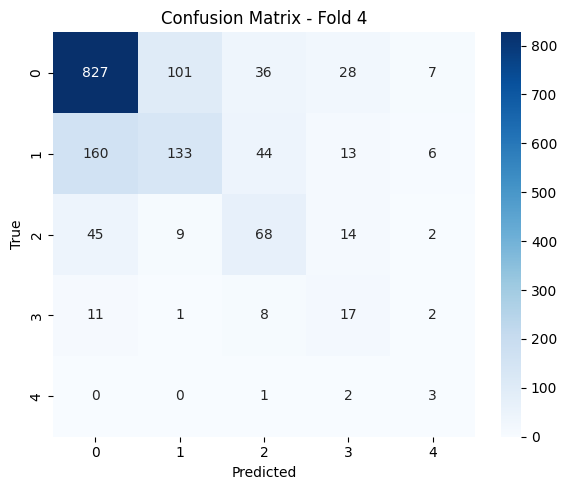

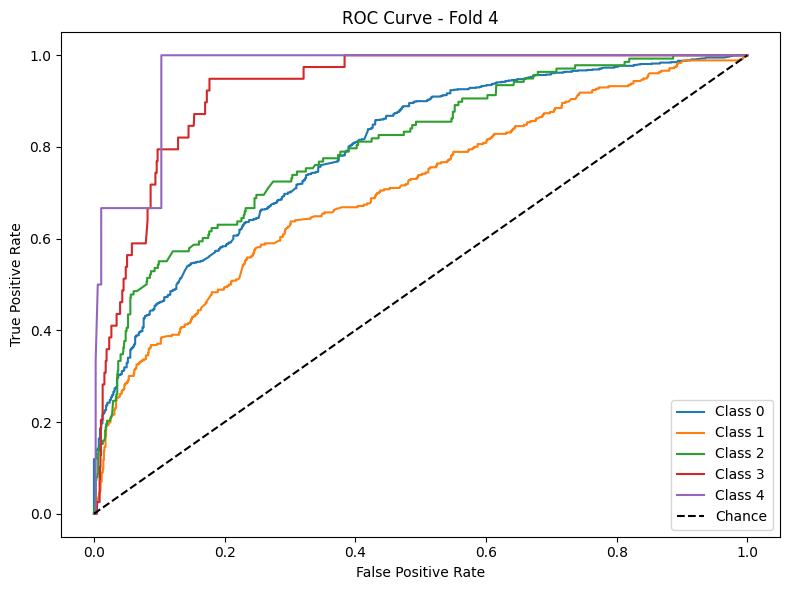

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 - 12s - 25ms/step - accuracy: 0.5182 - loss: 1.1000 - val_accuracy: 0.4928 - val_loss: 1.1093
Epoch 2/30
500/500 - 3s - 5ms/step - accuracy: 0.6478 - loss: 0.8569 - val_accuracy: 0.5878 - val_loss: 1.0154
Epoch 3/30
500/500 - 3s - 5ms/step - accuracy: 0.6776 - loss: 0.8108 - val_accuracy: 0.5702 - val_loss: 1.0371
Epoch 4/30
500/500 - 3s - 5ms/step - accuracy: 0.6945 - loss: 0.7792 - val_accuracy: 0.5722 - val_loss: 1.0104
Epoch 5/30
500/500 - 3s - 5ms/step - accuracy: 0.7032 - loss: 0.7552 - val_accuracy: 0.6040 - val_loss: 0.9564
Epoch 6/30
500/500 - 3s - 6ms/step - accuracy: 0.7127 - loss: 0.7352 - val_accuracy: 0.5923 - val_loss: 0.9513
Epoch 7/30
500/500 - 3s - 6ms/step - accuracy: 0.7168 - loss: 0.7224 - val_accuracy: 0.5657 - val_loss: 0.9615
Epoch 8/30
500/500 - 3s - 5ms/step - accuracy: 0.7236 - loss: 0.7108 - val_accuracy: 0.5741 - val_loss: 1.0041
Epoch 9/30
500/500 - 3s - 5ms/step - accuracy: 0.7261 - loss: 0.6993 - val_accuracy: 0.5962 - val_loss: 0.9760
Epoch 10/3

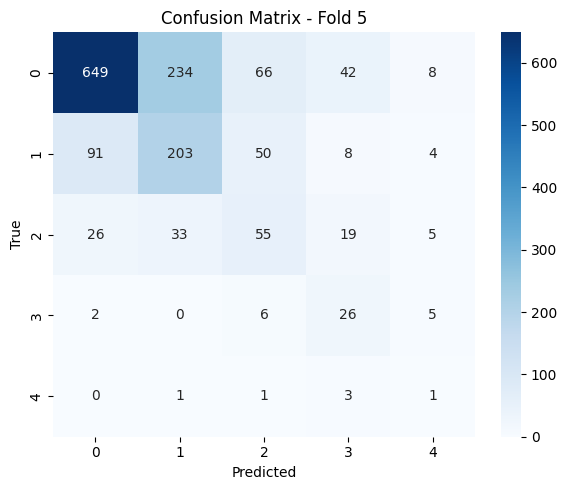

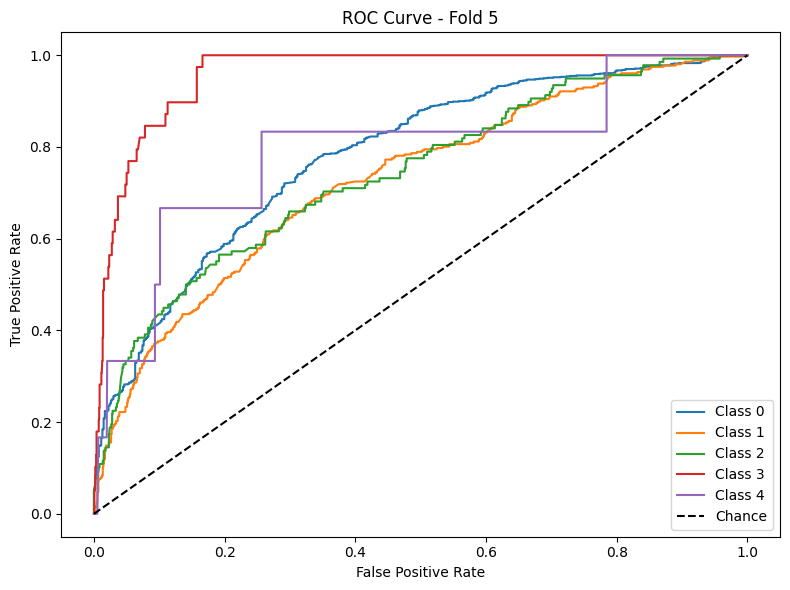


Average Accuracy: 0.6263
Average F1 Macro: 0.4219
Average AUC: 0.8097


In [8]:
# phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
# results = {}

# for i, phase_path in enumerate(phase_paths, start=1):
#     print(f"\n=== Training Phase {i} ===")
#     sample = True
#     model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
#     # Save best model & scaler
#     if sample: 
#         temp = "sample"
#     else: temp = "no_sample"
#     joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
#     joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
#     results[f"phase{i}"] = metrics


# from tensorflow.keras.models import save_model  # không bắt buộc nhưng rõ ràng

phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # ✅ Lưu model Keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # ✅ Lưu scaler sklearn
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       568
           1       0.33      0.35      0.34        63
           2       0.38      0.19      0.25        43
           3       0.15      0.13      0.14        15
           4       0.00      0.00      0.00         9

    accuracy                           0.81       698
   macro avg       0.35      0.32      0.33       698
weighted avg       0.79      0.81      0.80       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


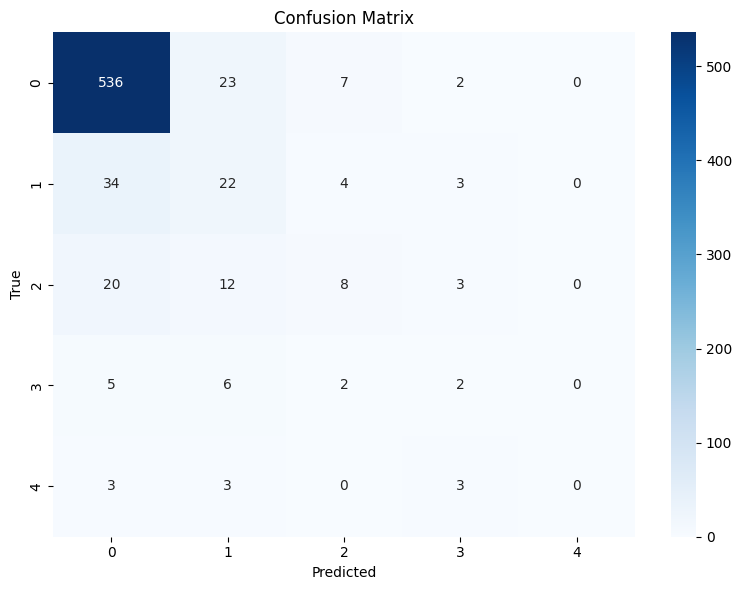


Test AUC (macro-average, OVR): 0.6401


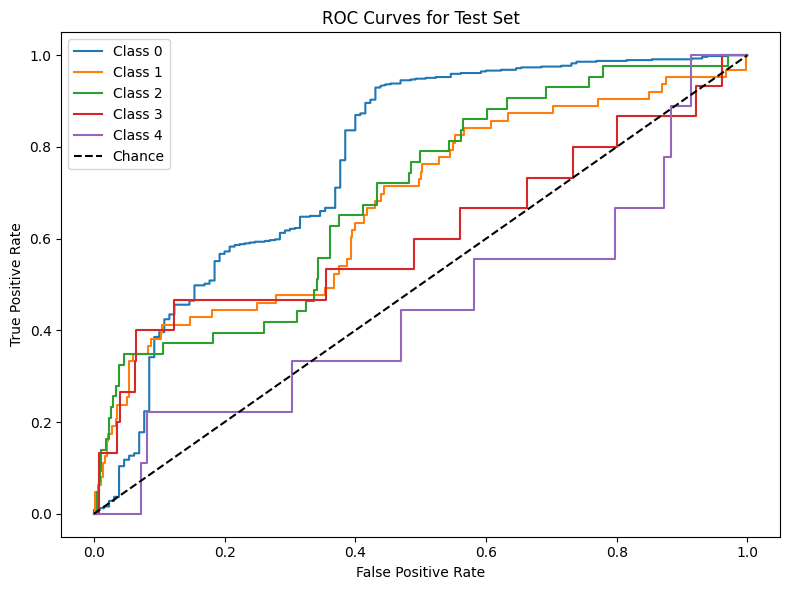

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       544
           1       0.15      0.20      0.17        59
           2       0.23      0.17      0.19        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.75       668
   macro avg       0.25      0.25      0.25       668
weighted avg       0.74      0.75      0.75       668



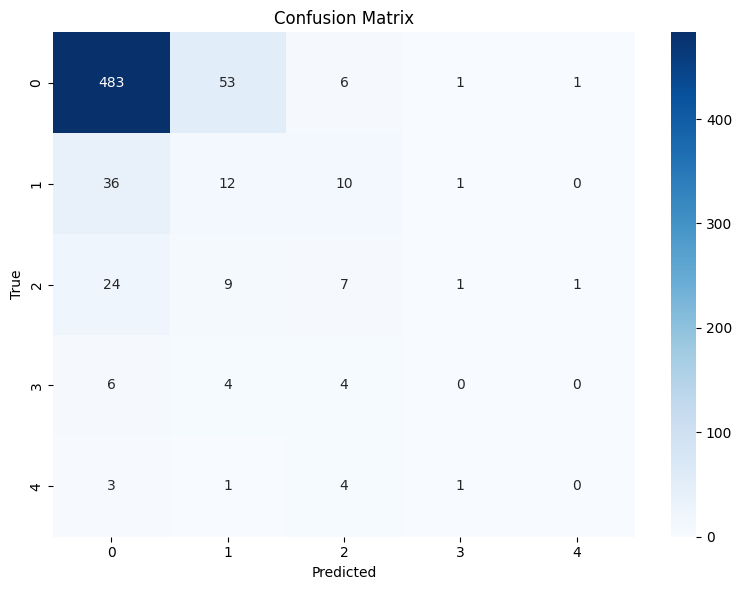


Test AUC (macro-average, OVR): 0.6470


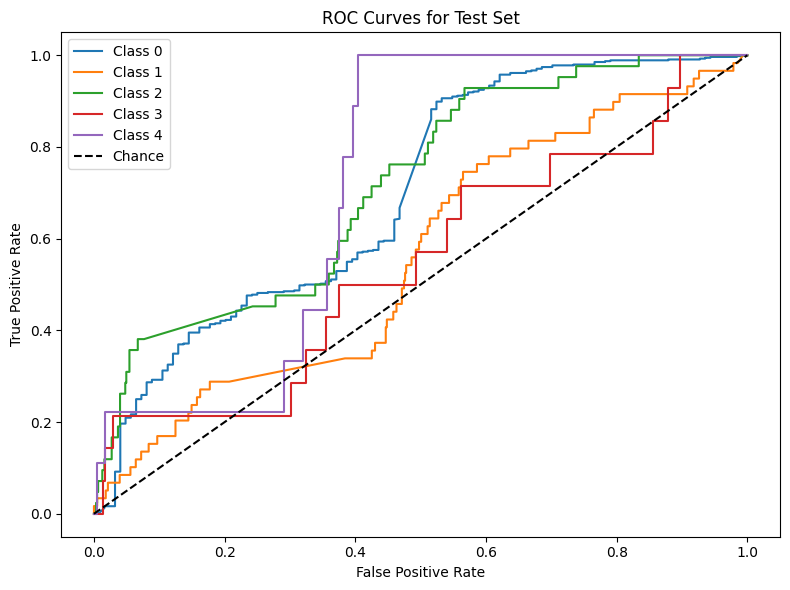

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       455
           1       0.11      0.15      0.13        52
           2       0.20      0.21      0.20        29
           3       0.23      0.30      0.26        10
           4       0.00      0.00      0.00         8

    accuracy                           0.72       554
   macro avg       0.28      0.30      0.29       554
weighted avg       0.74      0.72      0.73       554



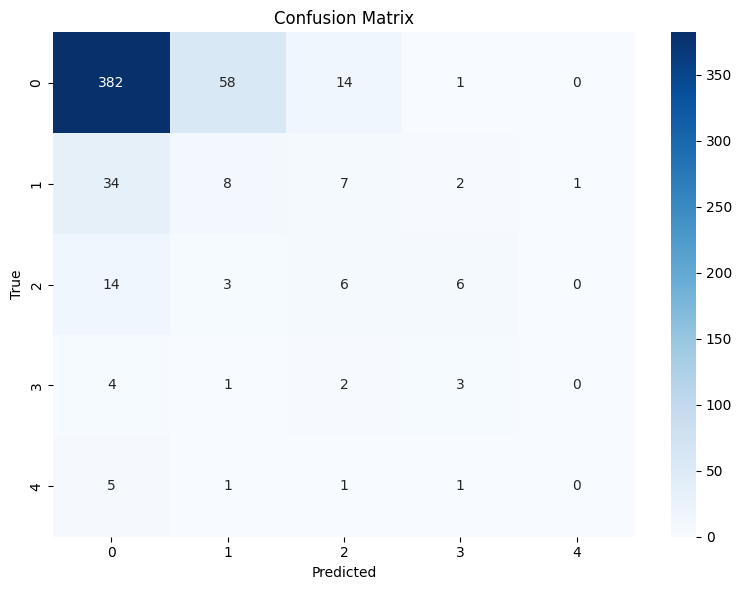


Test AUC (macro-average, OVR): 0.6434


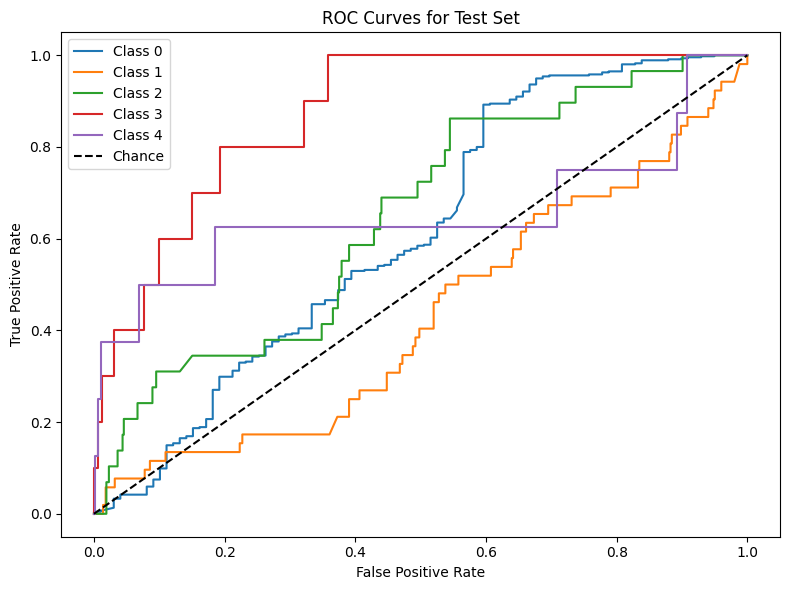

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       395
           1       0.23      0.23      0.23        40
           2       0.22      0.33      0.27        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       477
   macro avg       0.27      0.29      0.28       477
weighted avg       0.78      0.79      0.79       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


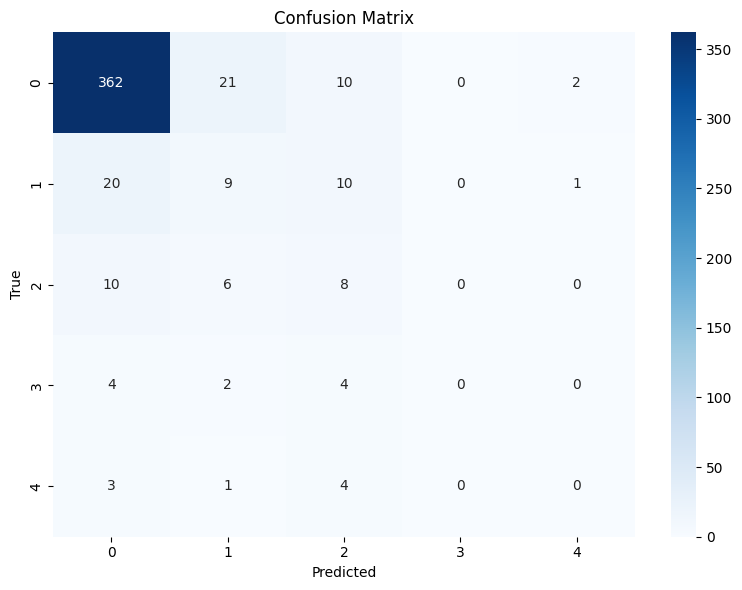


Test AUC (macro-average, OVR): 0.6421


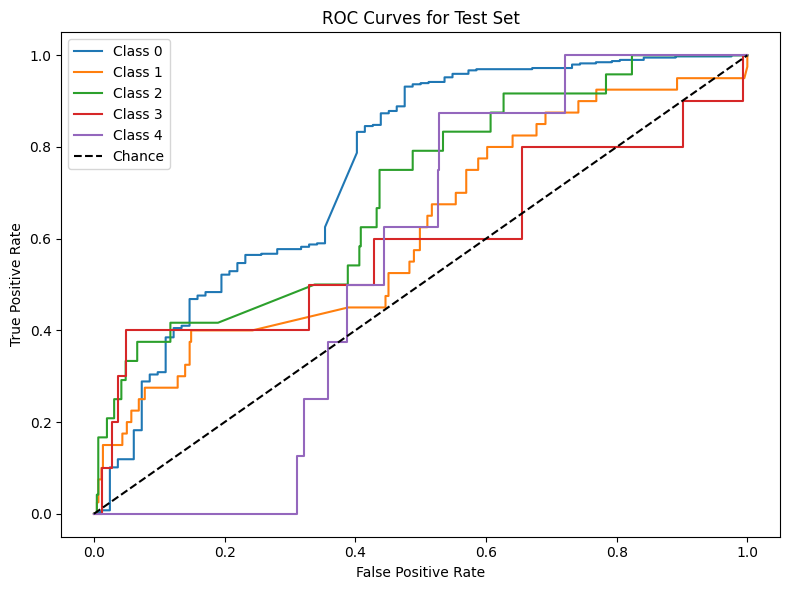

In [9]:
import glob

# for i in range(1, 5):
#     test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
#     # Get model and scaler using glob
#     model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
#     scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
#     # School mapping path
#     school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

#     # Predict on test set
#     predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)



from tensorflow.keras.models import load_model  # đảm bảo đã import đúng ở nơi dùng

# temp = "sample"  # hoặc "no_sample" — giống lúc bạn lưu model

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'

    # ✅ Đường dẫn đúng cho mô hình Keras .h5
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'

    # ✅ Đường dẫn mapping
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # ✅ Gọi hàm dự đoán đã tương thích với LSTM
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
